# Lublin House Prices Prediction

**Author:** Davyd Antoniuk

## 1. Introduction

**Project Goal:** Predicting House Prices in Lublin Using Machine Learning & Deep Learning algotithms.

This project aims to build an accurate model for predicting house prices in Lublin by comparing various machine learning and deep learning algorithms. The dataset was scraped from [Otodom](https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/lubelskie/lublin/lublin/lublin?viewType=listing&page=), then cleaned and preprocessed, including handling missing values and balancing price distribution.

Various models were trained and evaluated to identify the best-performing approach for price prediction, ensuring high accuracy and reliability in real estate price estimation.

## 2. Data Collection & Preprocessing

In [2]:
from help_functions import * 
from help_functions import evaluate_model, check_normality, check_feature_importance, detect_outliers_iqr, winsorize_series, get_kdist_plot, compute_weights, plot_metric_comparison, predict_house_price

c:\Users\davyd\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File `help_functions.py` contains all necessary libraries and functions used in this project.\
File link: https://github.com/davydantoniuk/lublin-house-price-predict/blob/main/help_functions.py

### 2.1 Data Scraping

The dataset was collected by scraping house listings from the [Otodom](https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/lubelskie/lublin/lublin/lublin?viewType=listing&page=) website using `R` with the libraries `rvest`, `dplyr`, and `stringr`. The [scraping R script](https://github.com/davydantoniuk/lublin-house-price-predict/blob/main/data/Web_Otodom_scrapper.Rmd) and the collected dataset is stored in `data/` folder.

### 2.2 Dataset Overview

In [3]:
data = pd.read_csv('data/houses_data.csv')
data.head()

,Price,Name,Rooms,Area,Floor,Region,Year,Elevator
0,567 000 zł,4-pokojowe LSM bez prowizji,4 pokoje,52.5 m²,3 piętro,Rury,brak informacji,nie
1,728 500 zł,Idealne mieszkanie 4 Pokoje ! 2 balkony ! Okazja,4 pokoje,77.5 m²,3 piętro,Czechów Północny,2025,tak
2,668 360 zł,Active City etap V | mieszkanie 4-pok. | D1_2_17,4 pokoje,68.2 m²,2 piętro,Wrotków,2026,tak
3,833 414 zł,"Mieszkanie, rynek pierwotny, KONCERTOWA 42",4 pokoje,76.46 m²,1 piętro,Czechów Południowy,2023,tak
4,696 500 zł,4 pokoje na nowym osiedlu blisko Centrum.,4 pokoje,79.6 m²,NaN,Kośminek,2025,tak


- Price – Listing price of the house/apartment.
- Name – Title of the listing.
- Rooms – Number of rooms in the property.
- Area – Total area in square meters.
- Floor – Floor number.
- Region – Region of the property.
- Year – Year of construction.
- Elevator – Indicates if the building has an elevator (Yes(*tak*)/No(*nie*)).

**Why These Features?**

I analyzed Otodom listings before ([web-otodom-analyse-r](https://github.com/davydantoniuk/web-otodom-analyse-r)) and found that these features appear in most listings and have the biggest impact on price. Other features are rarely filled, often missing, and would require much longer scraping time, making them less useful for modeling.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     3182 non-null   object
 1   Name      3182 non-null   object
 2   Rooms     3182 non-null   object
 3   Area      3182 non-null   object
 4   Floor     3121 non-null   object
 5   Region    3182 non-null   object
 6   Year      3182 non-null   object
 7   Elevator  3182 non-null   object
dtypes: object(8)
memory usage: 199.0+ KB


The dataset consists of 3182 entries and 8 columns, with all features stored as object (string) type. To ensure proper analysis and modeling, numerical columns need to be converted to their appropriate data types.

In [5]:
print("\nUnique values in each column (excluding 'Name', 'Price' and 'Area'):")
for column in data.columns:
    if column not in ['Name', 'Price', 'Area']:
        unique_values = data[column].unique()
        print(f"{column}: {unique_values}")


Unique values in each column (excluding 'Name', 'Price' and 'Area'):
Rooms: ['4 pokoje' '2 pokoje' '3 pokoje' '1 pokój' '5 pokoi' '6 pokoi'
 '10+ pokoi' '7 pokoi']
Floor: ['3 piętro' '2 piętro' '1 piętro' nan '10+ piętro' '10 piętro' '4 piętro'
 'parter' '6 piętro' '5 piętro' '9 piętro' '7 piętro' '8 piętro'
 'suterena' 'poddasze']
Region: ['Rury' 'Czechów Północny' 'Wrotków' 'Czechów Południowy' 'Kośminek'
 'Wieniawa' 'Ponikwoda' 'Śródmieście' 'Bronowice' 'Węglin Południowy'
 'Dziesiąta' 'Tatary' 'Felin' 'Kalinowszczyzna' 'Sławin' 'Czuby Północne'
 'Konstantynów' 'Szerokie' 'Czuby Południowe' 'Stare Miasto'
 'Za Cukrownią' 'Zemborzyce' 'Węglin Północny' 'Hajdów-Zadębie']
Year: ['brak informacji' '2025' '2026' '2023' '2015' '1980' '1982' '2008' '2024'
 '2018' '2003' '2021' '1976' '1963' '2017' '1969' '2000' '1978' '1975'
 '1983' '1993' '1974' '1995' '2022' '1994' '1897' '1986' '1984' '2010'
 '1988' '1973' '1996' '1967' '1972' '1964' '1998' '2014' '1990' '1977'
 '2005' '2012' '2016' '1

The `Year` column contains the unique value *brak informacji*, which should be replaced with **NaN**. Additionally, it includes unrealistic values like *1650*, *1* and *87*, which need to be handled appropriately. Let's check that observations

In [6]:
data[data["Year"].isin(["1650", "1", "87"])]

,Price,Name,Rooms,Area,Floor,Region,Year,Elevator
399,830 000 zł,"Stare Miasto, Idealne Pod Wynajem Krótkoterminowy",3 pokoje,65 m²,2 piętro,Stare Miasto,1650,nie
684,524 000 zł,Trzypokojowe mieszkanie piętro: 1/4,3 pokoje,62 m²,1 piętro,Czuby Północne,1,nie
2559,559 000 zł,Mieszkanie dla rodziny w świetnej lokalizacji,3 pokoje,66 m²,NaN,Czuby Północne,87,nie


The value *87* could likely represent *1987*, so it can be corrected accordingly. However, *1* and *1650* are difficult to interpret, making it more appropriate to replace them with `NaN` for better data consistency.

Additionally, the `Price` column also contains missing values, like *Zapytaj o cenę*, which should be replaced with **NaN**.

In [7]:
data[data["Price"] == "Zapytaj o cenę"].head(1) # Output only one example

,Price,Name,Rooms,Area,Floor,Region,Year,Elevator
33,Zapytaj o cenę,Narcyzowe Wzgórza II | mieszkanie 2-pok. | C_45,2 pokoje,32.33 m²,1 piętro,Ponikwoda,2026,tak


### 2.3 Data type conversions

Replace "Zapytaj o cenę" with NaN, removes non-numeric characters (spaces, "zł"), converts commas to dots, and changes the `Price` column to float.

In [8]:
# Replace 'Zapytaj o cenę' with NaN
data['Price'] = data['Price'].replace('Zapytaj o cenę', np.nan)

# Remove non-numeric characters, replace commas with dots, and convert to float, while keeping NaN values
data['Price'] = data['Price'].str.replace('\xa0', '').str.replace('zł', '').str.replace(',', '.').astype('float32')

Remove spaces and $m^2$ from the `Area` column and convert it to float.

In [9]:
# Remove non-numeric characters and convert 'Area' to float
data['Area'] = data['Area'].str.replace(' ', '').str.replace('m²', '').astype('float32')

Replace "brak informacji" and incorrect values in the `Year` column with NaN, convert valid years, and change the column type to integer while preserving NaN values.

In [10]:
# Replace 'brak informacji' with NaN in 'Year' column
data['Year'] = data['Year'].replace('brak informacji', np.nan)

# Replace '87' with 1987 and '1' with NaN in 'Year' column
data['Year'] = data['Year'].replace({'87': 1987, '1': np.nan, '1650': np.nan})

# Convert 'Year' to integer, while keeping NaN values
data['Year'] = data['Year'].astype(float).astype('Int32')

Replace "nie" with 0 and "tak" with 1 in the `Elevator` column, then convert it to integer.

In [11]:
# Convert 'Elevator' column to 0 if 'nie' and 1 if 'tak'
data['Elevator'] = data['Elevator'].replace({'nie': 0, 'tak': 1}).astype('int32')

Count the occurrences of each unique value in the `Rooms` column and display the results.

In [12]:
# Count the number of rows for each unique value in 'Rooms' column
room_counts = data['Rooms'].value_counts()
print("Number of rows for each unique value in 'Rooms' column:")
print(room_counts)

Number of rows for each unique value in 'Rooms' column:
Rooms
3 pokoje     1364
2 pokoje     1124
4 pokoje      404
1 pokój       232
5 pokoi        46
6 pokoi         7
7 pokoi         3
10+ pokoi       2
Name: count, dtype: int64


There are only two observations in the "Rooms" column that have 10+ rooms, so let's replace them with 10.

In [13]:
# Replace '10+ pokoi' with '10 pokoi' in 'Rooms' column
data['Rooms'] = data['Rooms'].replace('10+ pokoi', '10 pokoi')

# Extract numeric part and convert 'Rooms' to integer
data['Rooms'] = data['Rooms'].str.extract('(\d+)').astype('int32')

In [14]:
# Reorder columns
data = data[['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region', 'Name']]

As I already converse columns to proper data types, now let's check how dataset looks like.

In [15]:
data.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region,Name
0,567000.0,52.500000,0,<NA>,4,3 piętro,Rury,4-pokojowe LSM bez prowizji
1,728500.0,77.500000,1,2025,4,3 piętro,Czechów Północny,Idealne mieszkanie 4 Pokoje ! 2 balkony ! Okazja
2,668360.0,68.199997,1,2026,4,2 piętro,Wrotków,Active City etap V | mieszkanie 4-pok. | D1_2_17
3,833414.0,76.459999,1,2023,4,1 piętro,Czechów Południowy,"Mieszkanie, rynek pierwotny, KONCERTOWA 42"
4,696500.0,79.599998,1,2025,4,NaN,Kośminek,4 pokoje na nowym osiedlu blisko Centrum.


Dataset columns are in correct data types. `Floor` remains as a string because converting it to numbers could mislead the model into interpreting floors as strictly numerical, where higher numbers imply significantly greater height differences.

### 2.4 Check for Duplicate Listings

The scraper can accidentally collect the same listings multiple times, and I didn’t initially account for this when preparing the dataset. Since the model will train on columns excluding `Name`, I will check for duplicates based on all other property attributes to ensure data quality. 

In [16]:
# Count duplicate listings based on all key property attributes
duplicate_counts = data.groupby(['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']).size()

# Filter and display only duplicates (listings appearing more than once)
duplicates = duplicate_counts[duplicate_counts > 1].reset_index(name='Count')

duplicates.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region,Count
0,239000.0,33.689999,0,1908,2,parter,Dziesiąta,2
1,309100.0,30.910000,1,2025,2,2 piętro,Kośminek,2
2,344817.0,34.830002,1,2025,2,2 piętro,Ponikwoda,2
3,348000.0,42.500000,0,1996,2,4 piętro,Felin,4
4,349000.0,20.000000,1,1970,1,3 piętro,Rury,6


Dataset contains duplicates

Now let's remove duplicates with keeping the first occurrence. 

In [17]:
# Remove duplicate listings but keep one unique instance
data = data.drop_duplicates(subset=['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region'], keep='first')

In [18]:
len(data)

2578

After removing duplicates, the dataset decreased from 3182 to 2578 entries.

### 2.5 Missing Values Exploration

Now let's check for missing values in the dataset.

In [19]:
# Assuming 'data' is your DataFrame
missing_data = data.isnull().sum()
print("Missing data in each column:")
print(missing_data)

Missing data in each column:
Price       335
Area          0
Elevator      0
Year        381
Rooms         0
Floor        45
Region        0
Name          0
dtype: int64


Since `Price` is what the model is learning to predict, imputing it can create synthetic labels, which may harm the model's accuracy. So let's drop rows with missing values in the `Price` column.

In [20]:
# Drop rows with missing values in 'Price' column
data = data.dropna(subset=['Price'])

For missing values in `Year` and `Floor`, I will first handle them appropriately. Instead of using simple methods like *mean*, *median*, or *mode*, I will analyze the correlation matrix to explore relationships between features and determine if regression-based imputation is a better approach.

**Correlation matrix**

As I wrote before, since the `Floor` column is categorical, converting it directly to numerical values could mislead the model. A better approach is to use one-hot encoding for modeling. However, to analyze correlations and explore regression-based imputation, I will first create a temporary dataset where Floor is converted to numerical values to check the correlation matrix.

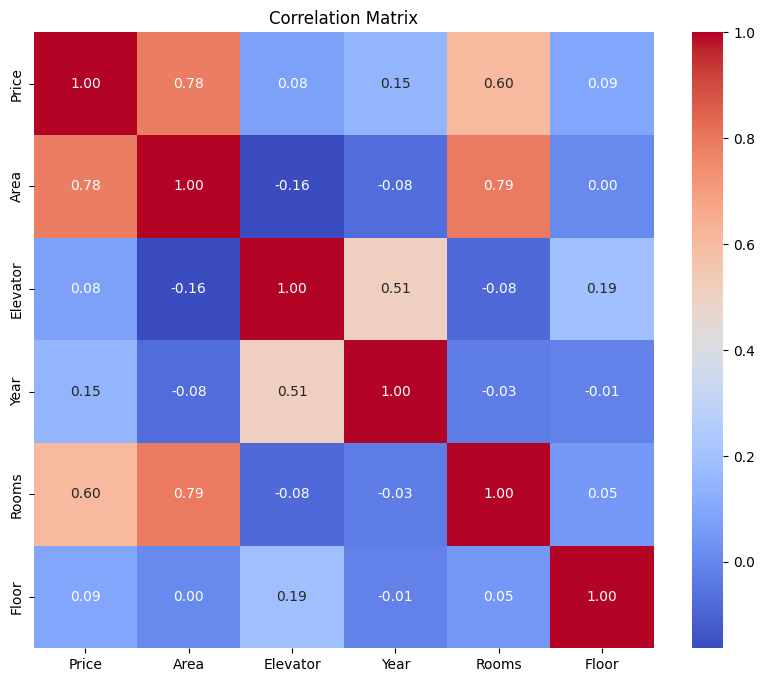

In [21]:
# Create a copy of the DataFrame
data_corr = data.copy(deep=True)
data_corr["Floor"] = data_corr["Floor"].str.extract('(\d+)').astype('Int32')

# Select only numeric columns
numeric_data = data_corr.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The `Year` and `Floor` columns show very low correlation with other features, meaning that using **regression-based imputation** to predict their missing values would not be a reliable approach.\
Additionally, we observe *high correlations* between:
- `Price` and `Area` (0.78)
- `Price` and `Rooms` (0.6)
- `Rooms` and `Area` (0.79)

These correlations are logically expected, as larger properties typically have more rooms and higher prices. 

There is also a moderate correlation (0.51) between `Year` and `Elevator`, which suggests that newer buildings are more likely to have elevators. This is reasonable, as modern construction standards often include elevators, while older buildings may lack them.


To fill the missing values in Year and Floor, I will use a `KNN Imputer`, which leverages similar observations to estimate missing values.

At this step, I couldn't use `KNN Imputer` because, as I researched, KNN imputation requires standardization first due to how distance calculations work.  

I will perform imputation in later steps. 

---

**When is better to use KNN imputer before or after standardization?**\
https://datascience.stackexchange.com/questions/53138/which-comes-first-multiple-imputation-splitting-into-train-test-or-standardiz
>If you use something like KNN imputation then it is necessary to standardize and then impute due to how distance calculations work

---

Now let's build premilinary model to check how it performs on the dataset. But before that I will save the dataset to a new file with `Name`, which I will use later once in **EDA**. 

For the model this column does not provide any valuable information. I scraped that column to verify if scrapper works correctly, because in the names there are often information about the number of rooms, area, region.

In [22]:
# Save converted data 
data.to_csv('data/conversion_data.csv', index=False)

In [23]:
# Drop 'Name' column
data = data.drop("Name", axis=1)

### 2.6 Preliminary Random Forest Model

I build this preliminary Random Forest model to establish a baseline performance before splitting, standardization, and handling missing values, helping to compare improvements in later stages.

For building this model, I use **One-Hot Encoding** since I couldn't find strong sources proving that trees work better with Label Encoding or One-Hot Encoding. For now, I choose One-Hot Encoding, but in future steps, I will experiment more because the best technique is the one that gives the best model performance.

In [24]:
data_rf1 = data.copy()

# Drop rows with missing values in 'Price' column
data_rf1 = data_rf1.dropna(subset=['Price'])

# One-hot encode 'Floor' and 'Region' columns
data_rf1 = pd.get_dummies(data_rf1, columns=['Floor', 'Region'], drop_first=True)

# Define features and target
features = data_rf1.drop('Price', axis=1)
target = data_rf1['Price']

# Split the data into train and test sets
X_train_rf1, X_test_rf1, y_train_rf1, y_test_rf1 = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model1.fit(X_train_rf1, y_train_rf1)

# Predict on test set
y_pred = rf_model1.predict(X_test_rf1)

# Evaluate the model
rf1_r2, rf1_mae, rf1_mse, rf1_rmse, rf1_mape, rf1_rmsle = evaluate_model(y_test_rf1, y_pred)
print(f"R^2: {rf1_r2:.4f}")
print(f"MAE: {rf1_mae:.2f}")       
print(f"RMSE: {rf1_rmse:.2f}")
print(f"MAPE: {rf1_mape:.2f}")
print(f"RMSLE: {rf1_rmsle:.4f}")

R^2: 0.8180
MAE: 52997.79
RMSE: 84562.87
MAPE: 8.83
RMSLE: 0.1257


The Random Forest model initially performed well despite missing values, achieving an $R^2$ score of 81%. The **MAE** of 52997.79 and **MAPE** of 8.83% suggest relatively low average errors, while the larger **RMSE** of 84562.87 meaning that a few predictions have very high deviations from the actual prices.

So, there is still *room for improvement*.

Let's additionally check the feature importance to understand which features have the most significant impact on price prediction.

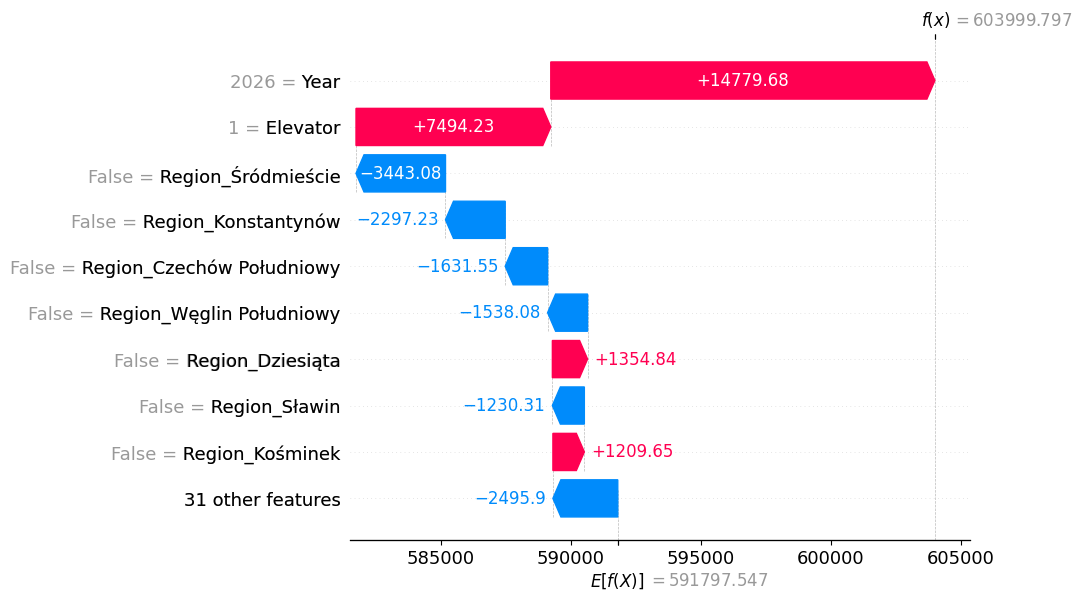

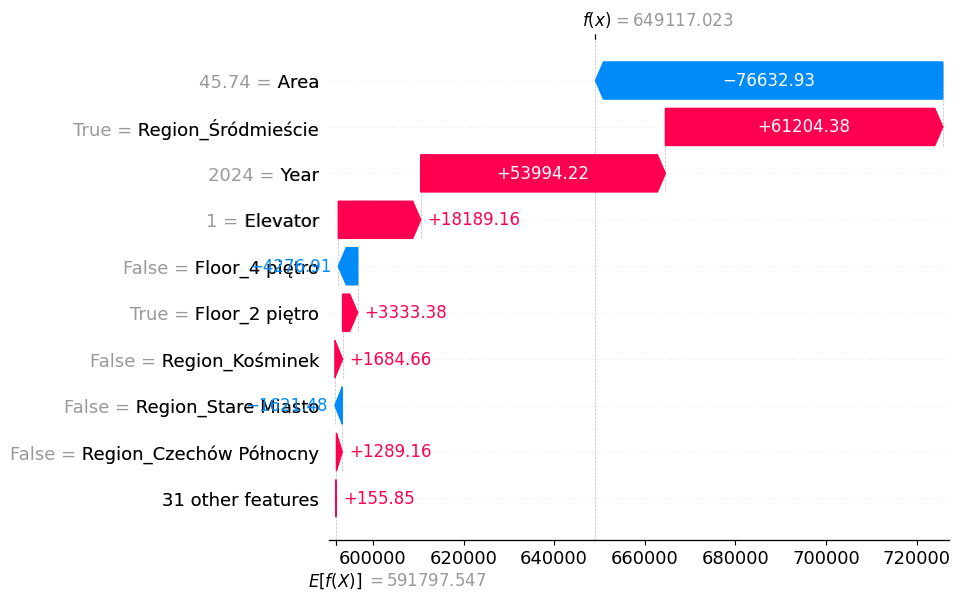

In [25]:
check_feature_importance(rf_model1, X_test_rf1,num_observations=2,random_seed=45)

For two different observations, different features had a dominant impact, showing that the model effectively considers multiple factors when predicting house prices. This highlights that features included in the model play a significant role in shaping predictions. 

## 3. Exploratory Data Analysis

Again look on the dataset to check if everything is correct.

In [26]:
data.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region
0,567000.0,52.500000,0,<NA>,4,3 piętro,Rury
1,728500.0,77.500000,1,2025,4,3 piętro,Czechów Północny
2,668360.0,68.199997,1,2026,4,2 piętro,Wrotków
3,833414.0,76.459999,1,2023,4,1 piętro,Czechów Południowy
4,696500.0,79.599998,1,2025,4,NaN,Kośminek


### 3.1 Basic Statistics

Since we have already cleaned the data, we can now study it in more detail

Let's see basic statistics of the dataset

In [27]:
numerical_cols = ["Price", "Area", "Elevator", "Year", "Rooms"]

# Basic statistics for numerical columns
numerical_stats = data[numerical_cols].describe().round(2)

numerical_stats

,Price,Area,Elevator,Year,Rooms
count,2243.00,2243.00,2243.00,1911.0,2243.00
mean,590925.19,56.06,0.52,2002.27,2.70
std,204863.22,19.66,0.50,29.25,0.89
min,99000.00,13.50,0.00,1815.0,1.00
25%,465839.00,44.12,0.00,1981.0,2.00
50%,554904.00,53.96,1.00,2018.0,3.00
75%,668000.00,64.07,1.00,2024.0,3.00
max,2900000.00,314.00,1.00,2027.0,10.00


- **Price**  
    Prices range from **99,000 PLN to 2,900,000 PLN**, with most listings falling between **465,839 PLN (25th percentile) and 668,000 PLN (75th percentile)**, indicating a moderate spread in property values. The high standard deviation (**204,863 PLN**) suggests significant price variation across listings.  

- **Area**  
    The average property size is **56.06 m²**, with most ranging between **44.12 m² and 64.07 m²**. There is moderate variation, but some large properties reach up to **314 m²**.  

- **Elevator**  
    About **52%** of properties have an elevator.  

- **Year**  
    The median year (**2018**) is significantly higher than the mean (**2002**) due to the presence of older buildings dating back to **1815**, which skews the average downward. Additionally, the years **2026 and 2027** indicate properties that are still under construction or planned for the future.  

- **Rooms**  
    Most properties have **2 to 3 rooms**, with an average of **2.7 rooms**. The number of rooms ranges from **1 to 10**, though larger apartments (**5+ rooms**) are less common. 🚀

In [28]:
categorical_cols = ["Floor", "Region"]

# Basic statistics for categorical columns 
categorical_stats = pd.DataFrame({
    "Unique Values": data[categorical_cols].nunique(),
    "Most Common Value": data[categorical_cols].mode().iloc[0],
    "Frequency": data[categorical_cols].apply(lambda x: x.value_counts().iloc[0])
})

categorical_stats

,Unique Values,Most Common Value,Frequency
Floor,14,1 piętro,458
Region,24,Śródmieście,227


The dataset includes 14 unique floor levels, with "1 piętro" being the most common (458 listings). Among 24 regions, "Śródmieście" appears most frequently (227 listings).

### 3.2 Price and Area Distribution

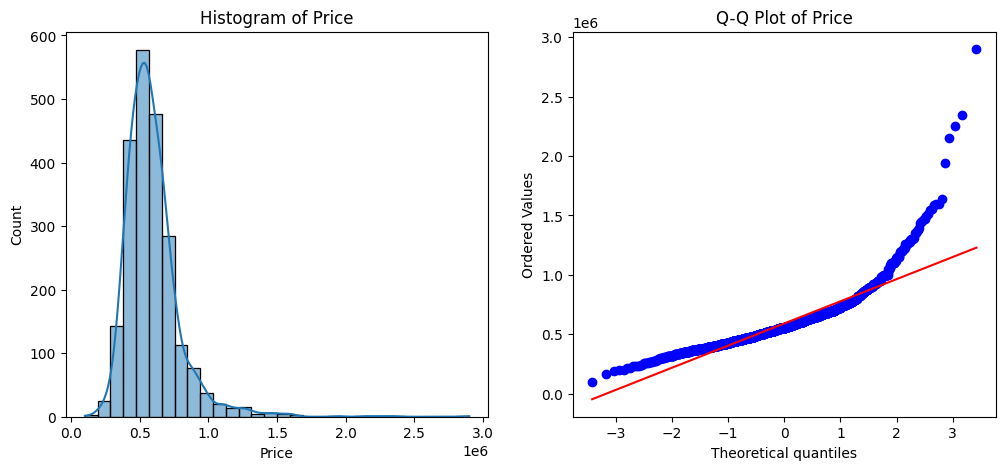

Normality Tests for Price:
  Shapiro-Wilk Test: W=0.8276, p-value=0.0000
  D'Agostino's K² Test: Stat=1428.4119, p-value=0.0000
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


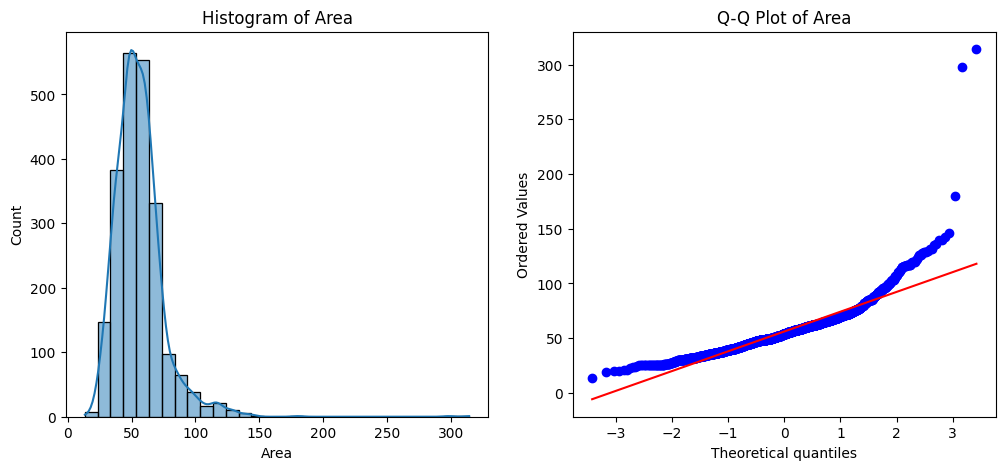

Normality Tests for Area:
  Shapiro-Wilk Test: W=0.8456, p-value=0.0000
  D'Agostino's K² Test: Stat=1598.3768, p-value=0.0000
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


In [29]:
cols = ["Price", "Area"]
check_normality(data, cols)

Both `Price` and `Area` failed the normality tests. This indicates that these variables are skewed or contain outliers. On Q-Q plots, we can notice distanced points from the line, which confirms the presence of outliers. 

### 3.4 Price per sqm Analysis

Price per sqm is a key metric for comparing properties of different sizes, detecting outliers, and understanding regional price trends. It provides deeper insights than analyzing price and area separately.

So, I will create a separate dataset and add the price per sqm column

In [30]:
# Create a separate dataset for price per sqm analysis
data_pricesqm = data.copy(deep=True)

# Calculate price per square meter
data_pricesqm['Price_per_sqm'] = data_pricesqm['Price'] / data_pricesqm['Area']

Now let's check the normality of the price per sqm

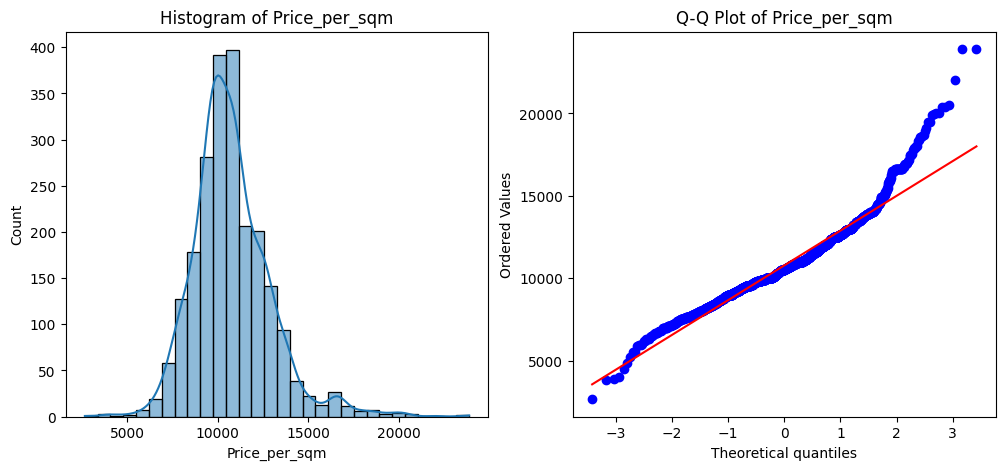

Normality Tests for Price_per_sqm:
  Shapiro-Wilk Test: W=0.9441, p-value=0.0000
  D'Agostino's K² Test: Stat=470.0948, p-value=0.0000
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


In [31]:
cols = ["Price_per_sqm"]
check_normality(data_pricesqm, cols)

The `Price_per_sqm` distribution is **not normal**, as shown by the histogram, Q-Q plot deviations, and rejected normality tests. It has slight skewness and some outliers.

Statistics for Price_per_sqm

In [32]:
# Display statistics for Price_per_sqm
price_per_sqm_stats = data_pricesqm['Price_per_sqm'].describe()
print(price_per_sqm_stats)

count     2243.000000
mean     10778.232422
std       2168.186768
min       2666.631836
25%       9500.000000
50%      10521.500000
75%      11896.666504
max      23900.000000
Name: Price_per_sqm, dtype: float64


The average price per sqm is **10,778 PLN**, with most values ranging between **9,500 PLN (25%)** and **11,896 PLN (75%)**. The distribution has a **wide spread (std: 2,168 PLN)** and some **high-value outliers**, reaching a maximum of **23,900 PLN**, while the minimum is **2,667 PLN**. 🚀

Create a boxplot to detect outliers

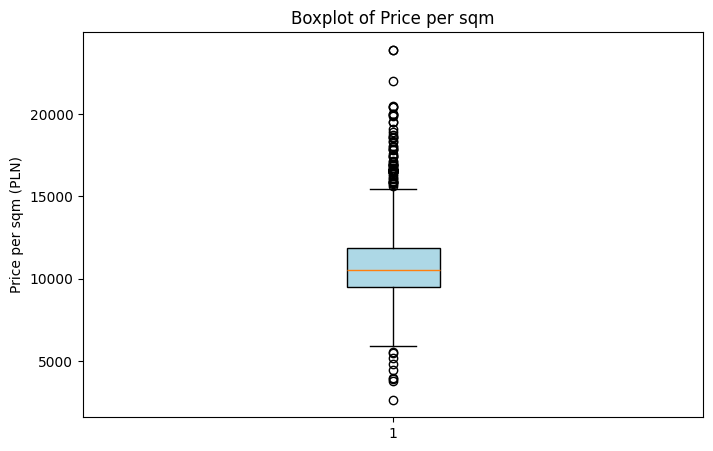

In [33]:
# Boxplot for Price_per_sqm
plt.figure(figsize=(8, 5))
plt.boxplot(data_pricesqm['Price_per_sqm'].dropna(), patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot of Price per sqm")
plt.ylabel("Price per sqm (PLN)")
plt.show()

The boxplot confirms the presence of many outliers, both on the lower and higher ends of price per sqm. Most values fall between ~9,500 PLN and ~12,000 PLN, with a few extreme cases exceeding 20,000 PLN. The distribution is slightly right-skewed, indicating that some high-end properties significantly raise the upper range.

Outliers in `price per sqm` can indicate **data entry errors**, **luxury properties**, or **undervalued listings.** By examining properties below the lower whisker and above 20,000 PLN per sqm, I can better understand market anomalies and decide whether to remove, adjust, or keep them for modeling.

To ensure if this is outliers or not I will additionally output `Name` column to check if there are any valuable information about the properties.

In [34]:
# Define IQR boundaries
Q1 = data_pricesqm['Price_per_sqm'].quantile(0.25)
Q3 = data_pricesqm['Price_per_sqm'].quantile(0.75)
IQR = Q3 - Q1

# Lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter lower outliers (unusually cheap properties)
low_outliers = data_pricesqm[data_pricesqm['Price_per_sqm'] < lower_bound]

# Filter high outliers (luxury or overpriced properties above 20,000 PLN per sqm)
high_outliers = data_pricesqm[data_pricesqm['Price_per_sqm'] > 20000]

# Load the dataset with property names
conversion_data = pd.read_csv("data/conversion_data.csv")  # Load full dataset

# Merge based on matching 'Price' and 'Region' to reduce NaNs
low_outliers = low_outliers.merge(
    conversion_data, 
    on=['Price', 'Region'], 
    how='left'
)

high_outliers = high_outliers.merge(
    conversion_data, 
    on=['Price', 'Region'], 
    how='left'
)

# Display all columns for deeper analysis
print("Lower outliers (unusually cheap properties):")
display(low_outliers)

print("High outliers (luxury or overpriced properties):")
display(high_outliers)

Lower outliers (unusually cheap properties):


,Price,Area_x,Elevator_x,Year_x,Rooms_x,Floor_x,Region,Price_per_sqm,Area_y,Elevator_y,Year_y,Rooms_y,Floor_y,Name
0,499000.0,128.000000,0,1960,4,4 piętro,Tatary,3898.437500,128.00,0,1960.0,4,4 piętro,Mieszkanie antresola+klimatyzacja 128m² użytko...
1,99000.0,19.000000,0,<NA>,1,parter,Dziesiąta,5210.526367,19.00,0,NaN,1,parter,Kawalerka ⭐️ ul. Kunickiego ⭐️ Okazja
2,190237.5,71.339996,0,<NA>,4,NaN,Czuby Południowe,2666.631836,71.34,0,NaN,4,NaN,"Mieszkanie ul. Ametystowa ,Lublin"
3,385000.0,79.150002,0,1910,4,3 piętro,Śródmieście,4864.181641,48.00,0,1969.0,3,4 piętro,"Mieszkanie, Kalinowszczyzna, ul. Okrzei, 48 m2"
4,385000.0,79.150002,0,1910,4,3 piętro,Śródmieście,4864.181641,79.15,0,1910.0,4,3 piętro,Czteropokojowe mieszkanie w ścisłym centrum Lu...
5,169000.0,37.549999,0,<NA>,2,2 piętro,Śródmieście,4500.666016,37.55,0,NaN,2,2 piętro,*Centrum*2 pokoje*z najemcami*inwestycja*
6,270000.0,49.000000,0,<NA>,2,parter,Dziesiąta,5510.204102,49.00,0,NaN,2,parter,Mieszkanie w kaminiecy przy ulicy Dziesiątej
7,475000.0,124.000000,0,1980,5,1 piętro,Kośminek,3830.645264,124.00,0,1980.0,5,1 piętro,Mieszkanie z prywatnym ogrodem
8,428000.0,107.000000,0,1910,2,1 piętro,Dziesiąta,4000.000000,107.00,0,1910.0,2,1 piętro,Dwa mieszkania w kamienicy o pow.107 m2. Udziały.
9,999000.0,180.000000,0,1998,5,3 piętro,Czechów Północny,5550.000000,180.00,0,1998.0,5,3 piętro,"Dwupoziomowe, 5 Pokoi Po Remoncie, Piwnica, Garaż"


High outliers (luxury or overpriced properties):


,Price,Area_x,Elevator_x,Year_x,Rooms_x,Floor_x,Region,Price_per_sqm,Area_y,Elevator_y,Year_y,Rooms_y,Floor_y,Name
0,956000.0,40.000000,1,2023,2,2 piętro,Śródmieście,23900.0,40.00,1,2023.0,2,2 piętro,Mieszkanie W Centrum O Wysokim Standardzie
1,752850.0,31.500000,1,2023,2,2 piętro,Śródmieście,23900.0,31.50,1,2023.0,2,2 piętro,Mieszkanie W Centrum O Wysokim Standardzie
2,1439305.0,70.209999,1,2022,2,2 piętro,Śródmieście,20500.0,70.21,1,2022.0,2,2 piętro,Apartament 2- pok. centrum- Litevski Art Resid...
3,927384.0,45.459999,1,<NA>,2,4 piętro,Śródmieście,20400.0,45.46,1,NaN,2,4 piętro,"Mieszkanie, 45,46 m², Lublin"
4,954720.0,46.799999,1,2024,3,4 piętro,Śródmieście,20400.0,46.80,1,2024.0,3,4 piętro,Niecała Prestige Residence | nowe mieszkanie M24
5,858000.0,39.000000,1,<NA>,2,parter,Śródmieście,22000.0,39.00,1,NaN,2,parter,"Mieszkanie, 39 m², Lublin"


The advertisements mostly **look like normal listings**, and the names don’t reveal clear anomalies. This makes it **risky to remove them**, as they could be legitimate properties rather than errors.

### 3.4 Regional Analysis

Number of unique values for each region.

In [35]:
data["Region"].value_counts()

Region
Śródmieście           227
Sławin                212
Ponikwoda             191
Wrotków               187
Czechów Południowy    173
Czechów Północny      162
Rury                  155
Węglin Południowy     148
Wieniawa              108
Dziesiąta              92
Kośminek               87
Czuby Północne         85
Bronowice              65
Stare Miasto           65
Kalinowszczyzna        60
Konstantynów           60
Tatary                 50
Czuby Południowe       47
Felin                  37
Szerokie               14
Za Cukrownią           11
Zemborzyce              3
Węglin Północny         2
Hajdów-Zadębie          2
Name: count, dtype: int64

**Śródmieście**, **Sławin**, and **Ponikwoda** have the highest number of listings, while **Węglin Północny** and **Hajdów-Zadębie** have the fewest. Regions with very few listings might make predictions less accurate. To improve the model, it could help to group similar regions or apply techniques like *weighting* or *regularization*. . I will describe my approach in the later part of the project.

**Bar chart**: Average price per region to identify the most expensive and cheapest areas.

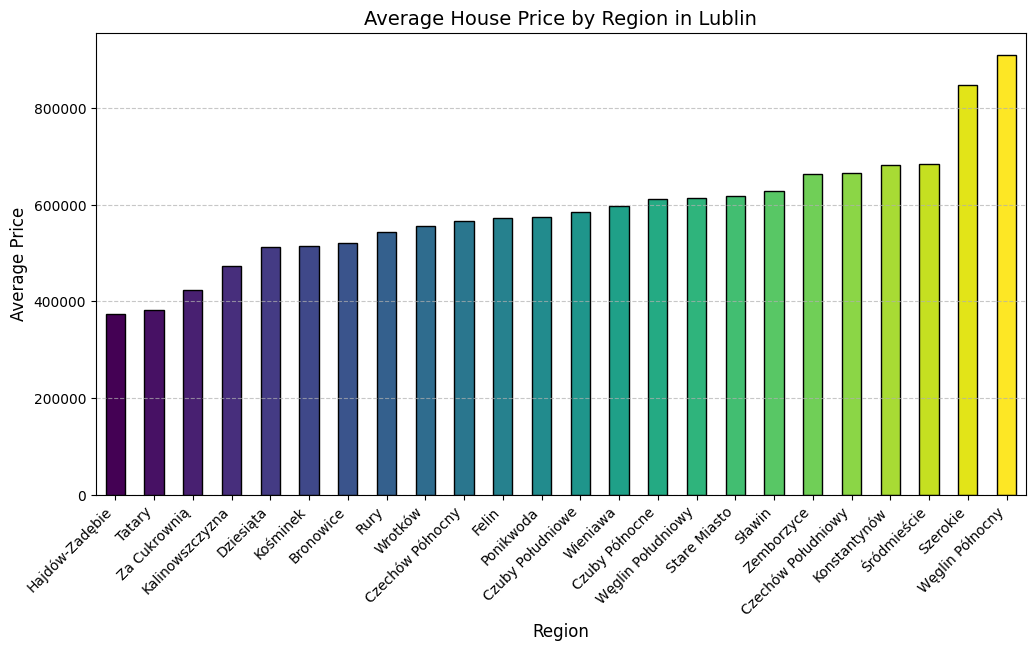

In [36]:
region_avg_price = data.groupby("Region")["Price"].mean().sort_values()

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(region_avg_price)))

# Plot the bar chart
plt.figure(figsize=(12, 6))
region_avg_price.plot(kind="bar", color=colors, edgecolor="black")
plt.xlabel("Region", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.title("Average House Price by Region in Lublin", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Węglin Północny** and **Szerokie** has the highest average house prices, while **Hajdów-Zadębie** has the lowest. The significantly higher average price in **Węglin Północny** and **Szerokie** might be due to the availability of a larger number of apartments in that region. So let's verify it with *pandas*.

In [37]:
filtered_data = data[(data["Region"].isin(["Węglin Północny", "Szerokie"])) & (data["Rooms"] > 4)]
room_count = filtered_data["Region"].value_counts()
display(filtered_data)
    
room_count

,Price,Area,Elevator,Year,Rooms,Floor,Region
444,999000.0,140.0,0,2000,5,1 piętro,Węglin Północny
2937,2900000.0,298.0,0,2003,10,1 piętro,Szerokie


Region
Węglin Północny    1
Szerokie           1
Name: count, dtype: int64

The high average prices in Węglin Północny and Szerokie are likely due to the low number of listings and the presence of more expensive, large apartments, which highly increase the average price.

### 3.5 Floor Analysis

Number of unique values for each floor level.

In [38]:
data['Floor'].value_counts()

Floor
1 piętro      458
3 piętro      431
parter        413
2 piętro      391
4 piętro      249
5 piętro       93
6 piętro       61
7 piętro       35
9 piętro       22
10 piętro      20
8 piętro       15
10+ piętro      8
suterena        1
poddasze        1
Name: count, dtype: int64

Similar to `Regions`, the distribution of listings across `Floors` is uneven. Lower **floors (1-4) and parter** have significantly more listings, while higher **floors (8+)** and unique categories like **suterena** and **poddasze** have very few. This imbalance also could affect model accuracy, as it may struggle to predict prices for less common floor types. In the later part of the project, I will outline my approach to address this issue and ensure a more balanced model. 

**Bar chart**: Average price per floor category to determine which floor levels are most expensive.

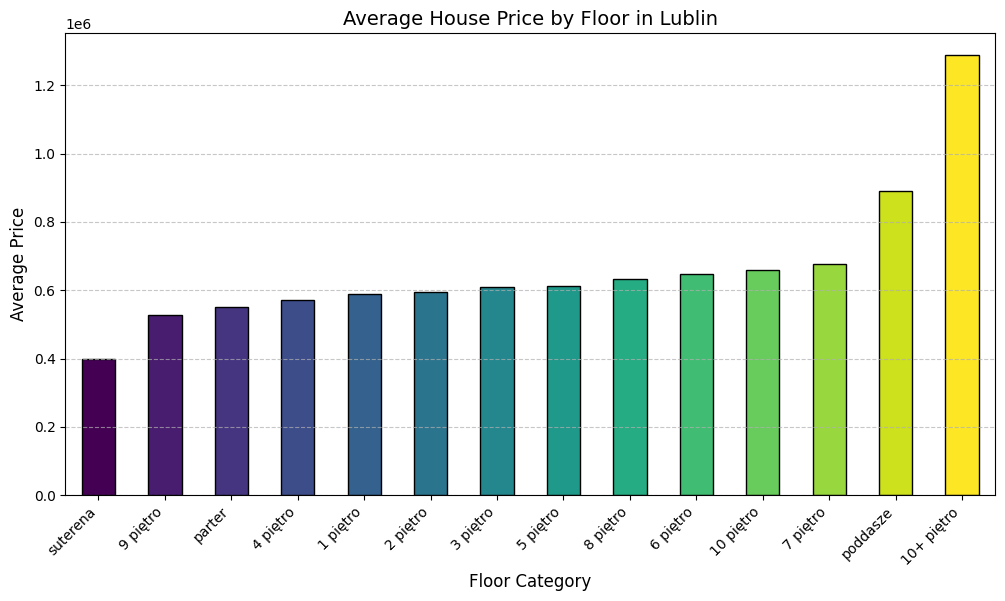

In [39]:
# Group by Floor and calculate the average price
floor_avg_price = data.groupby("Floor")["Price"].mean().sort_values()

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(floor_avg_price)))

# Plot the bar chart
plt.figure(figsize=(12, 6))
floor_avg_price.plot(kind="bar", color=colors, edgecolor="black")
plt.xlabel("Floor Category", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.title("Average House Price by Floor in Lublin", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Most floors have relatively stable average prices, but **poddasze** and **10+ piętro** stand out with significantly higher prices. This could be due to penthouse apartments or luxury properties on these floors, in next step we check it. **Suterena** has the lowest average price, likely due to lower demand. Other floar levels have similar average prices, indicating that floor level alone may not be a strong predictor of price.


Let's check the observations where the floor is *poddasze*, *suterena* and *10+ piętro* to verify how they look like.

In [40]:
# Filtering the dataset for the specified floor categories: "poddasze", "suterena", and "10+ piętro"
filtered_floors = data[data["Floor"].isin(["poddasze", "suterena", "10+ piętro"])]
grouped_floors = filtered_floors.groupby("Floor").apply(lambda x: x.head(20)).reset_index(drop=True)
grouped_floors

,Price,Area,Elevator,Year,Rooms,Floor,Region
0,538000.0,41.439999,1,2015,2,10+ piętro,Rury
1,1499000.0,88.199997,1,2019,4,10+ piętro,Czechów Południowy
2,1299000.0,81.000000,1,2013,3,10+ piętro,Rury
3,585000.0,33.330002,1,2023,2,10+ piętro,Czechów Południowy
4,1450000.0,103.010002,1,2023,5,10+ piętro,Czechów Południowy
5,530000.0,48.200001,1,1977,3,10+ piętro,Stare Miasto
6,2150000.0,130.000000,1,2013,4,10+ piętro,Czechów Południowy
7,2250000.0,131.199997,1,2020,5,10+ piętro,Czechów Południowy
8,890000.0,85.000000,0,1911,5,poddasze,Dziesiąta
9,399000.0,60.500000,0,1992,3,suterena,Sławin


**poddasze** is one old apartment with 5 rooms, which could explain it's high price.\
**suterena** is a 1992-built apartment with 3 rooms and no elevator, likely contributing to its lower price. \
**10+ piętro** show a wide range of prices, likely influenced by area, number of rooms, and location. Large aprtment with 10 rooms and 314 m² area has the highest price, but this is too strange observation, because is too large for 10+ floor. It could be a mistake made by the author of the announcement, so I will remove this observation.

In [41]:
data = data.drop(data[(data['Area'] == 314.0) & (data['Floor'] == "10+ piętro")].index)

### 3.6 Temporal Trends

**Scatter plot**: Year vs. Price to see if newer buildings are more expensive.

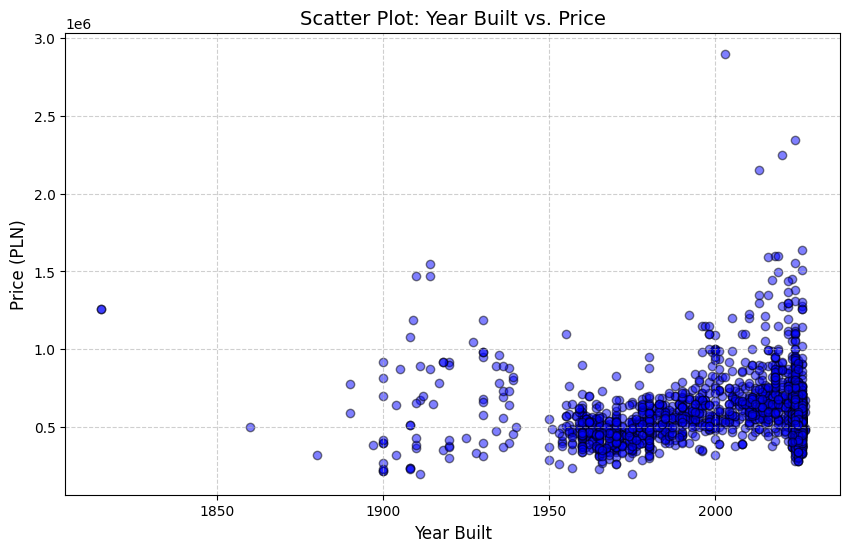

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(data["Year"], data["Price"], alpha=0.5, color="blue", edgecolors="black")

# Labels and title
plt.xlabel("Year Built", fontsize=12)
plt.ylabel("Price (PLN)", fontsize=12)
plt.title("Scatter Plot: Year Built vs. Price", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()

The scatter plot shows a weak relationship between year built and price, meaning newer buildings are not always more expensive. 
- There is one outlier from before 1850, which may be a historic or incorrectly recorded property.
- The 1850-1950 range has very few observations, which could make predictions for older buildings unreliable.
- This imbalance may affect model accuracy, as it will have less data to learn patterns for very old properties.

Additionally, there are three observations with significantly higher prices, which also is necessary to check.

In the later part of the project, I will propose a solution to address this issue and improve model performance. 

### 3.7 Elevator Analysis

- **Bar chart**: Average price comparison for properties with and without elevators.
- **Stacked bar chart**: Number of properties with and without elevators per floor category.

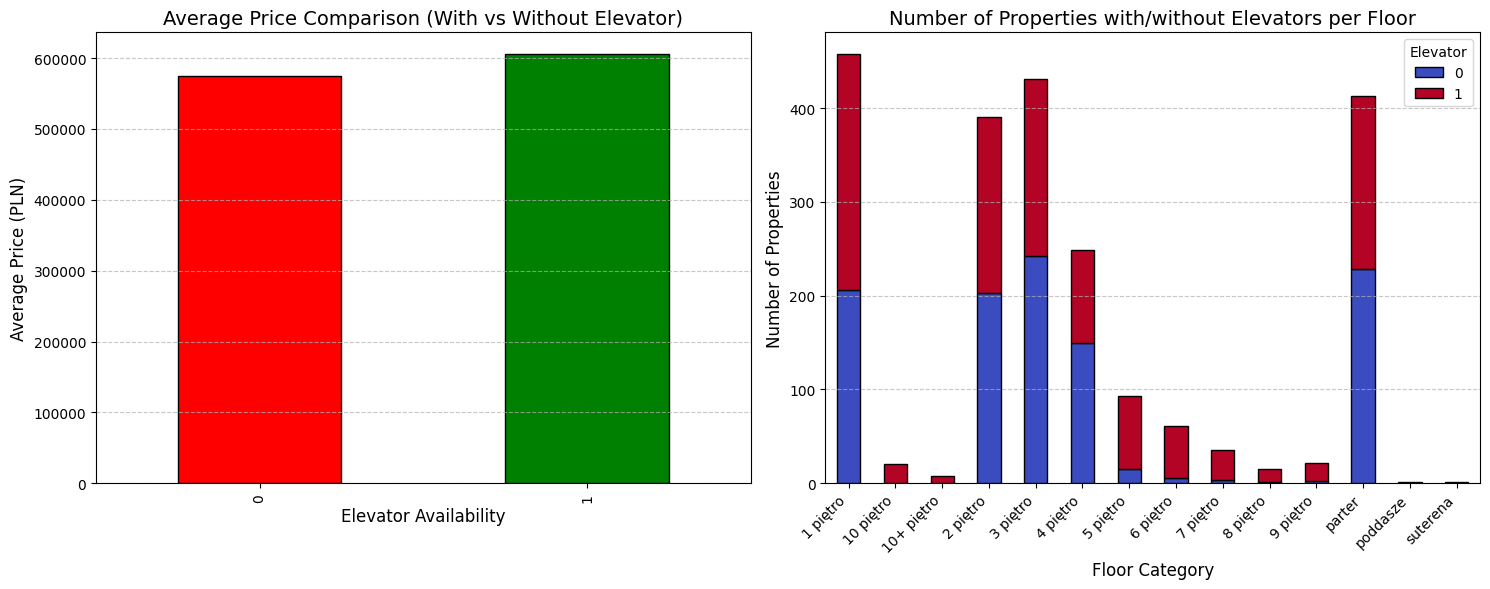

In [43]:
# First plot: Average price comparison for properties with and without elevators
avg_price_elevator = data.groupby("Elevator")["Price"].mean()

# Second plot: Stacked bar chart - Number of properties with and without elevators per floor category
elevator_per_floor = data.groupby(["Floor", "Elevator"]).size().unstack(fill_value=0)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart: Average price comparison
avg_price_elevator.plot(kind="bar", ax=axes[0], color=["red", "green"], edgecolor="black")
axes[0].set_xlabel("Elevator Availability", fontsize=12)
axes[0].set_ylabel("Average Price (PLN)", fontsize=12)
axes[0].set_title("Average Price Comparison (With vs Without Elevator)", fontsize=14)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Stacked bar chart: Number of properties with and without elevators per floor
elevator_per_floor.plot(kind="bar", stacked=True, ax=axes[1], colormap="coolwarm", edgecolor="black")
axes[1].set_xlabel("Floor Category", fontsize=12)
axes[1].set_ylabel("Number of Properties", fontsize=12)
axes[1].set_title("Number of Properties with/without Elevators per Floor", fontsize=14)
axes[1].legend(title="Elevator", loc="upper right")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels for better readability
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Show the plots
plt.tight_layout()
plt.show()

As we remember from basic statistics, about 53% of properties have an elevator. The average price for properties with elevators is few higher than for those without, but the difference is not significant. Higher floors buildings mostly have elevators, while in advertisements with lower floors, the presence of an elevator is less common.

### 3.8 Price and Property Characteristics

In this section, I will analyze key property characteristics - price, area, and number of rooms—using box plots. These visualizations help identify the **distribution**, **spread**, and **presence of outliers** in each variable.

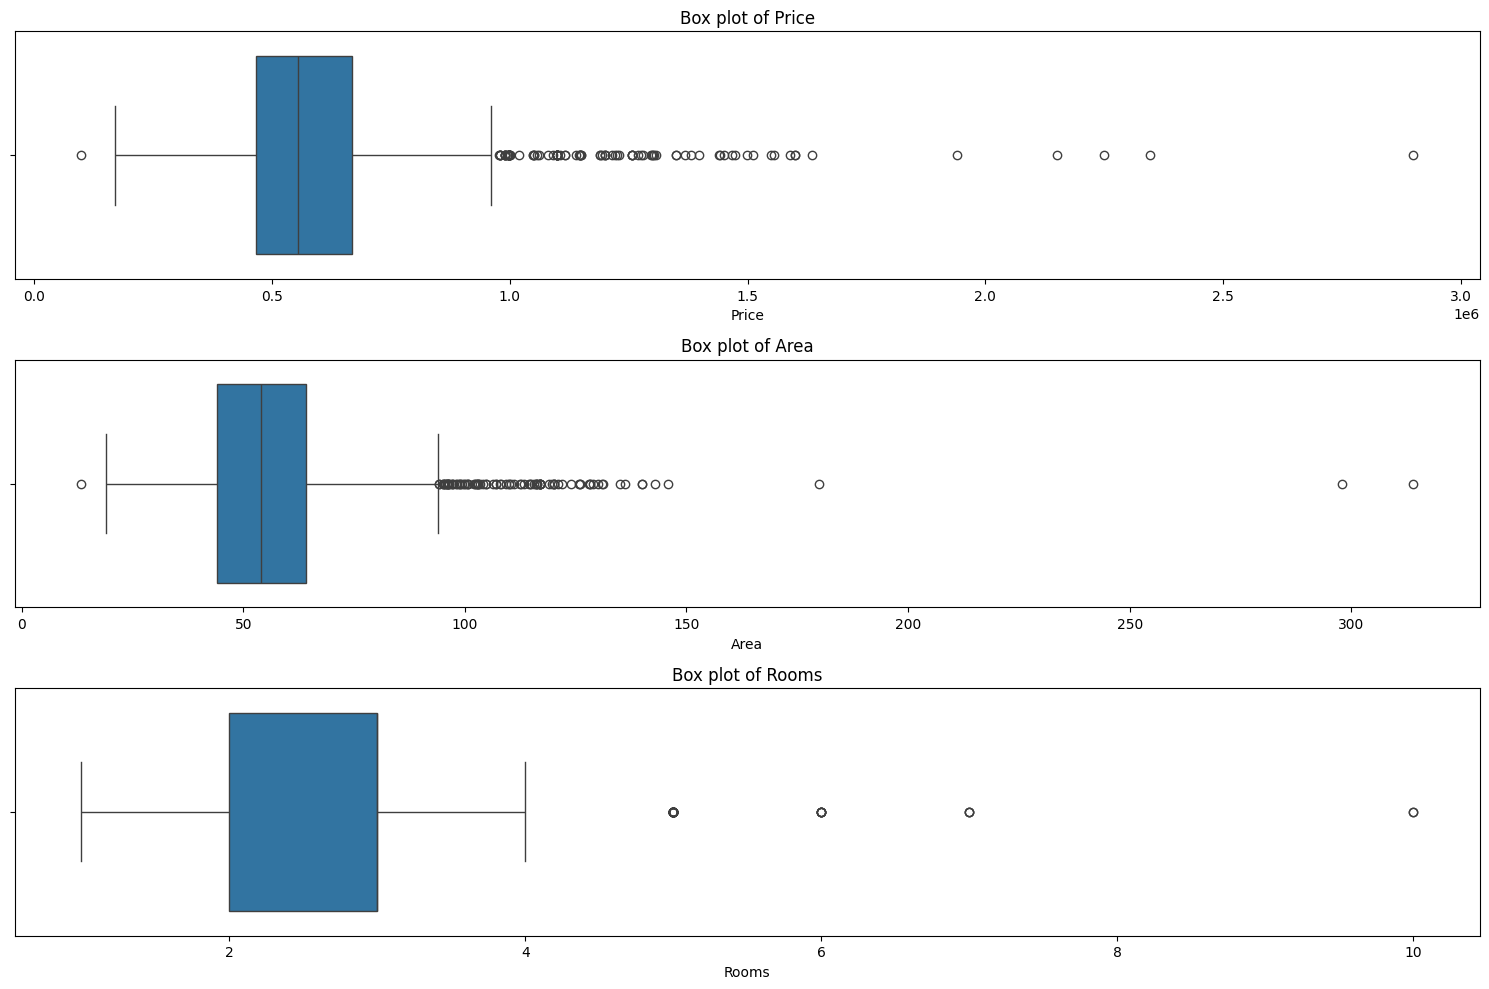

In [44]:
numerical_columns = ['Price', 'Area', 'Rooms']
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=data[column], orient='h')
    plt.title(f'Box plot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

**Box Plot of Price**
Most house prices fall within a certain range, with a few outliers extending significantly beyond 1,500,000 PLN. The median price is located in the lower portion of the box, suggesting that most properties are closer to the lower price range.

**Box Plot of Area**
Most house areas are between approximately 30 sqm and 100 sqm.There are several outliers representing houses with exceptionally large areas (over 150 sqm).

**Box Plot of Rooms:**
The majority of listings have 2 to 4 rooms. However, there are several outliers with 5+ rooms.

### 3.9 Analysis Results

Such a broad analysis helped us to familiarize ourselves with the data and understand its concept in more detail. Each step of the analysis revealed strange ads, a lack of relevant types, and outliers in the data. 

- Price and area do not follow a normal distribution, with a right skew indicating 
- Imbalanced number of observations across regions, with some regions having significantly more listings than others.
- Imbalanced floor distribution, with some floors having significantly more listings and a higher average price.
- Outliers in Price, Area, Rooms, and Year, with extreme values that may indicate errors
- Price per sqm shows high variability, with some extreme outliers suggesting overpriced or underpriced properties.

So in next stage, I will address these issues and prepare the data for modeling.

## 4. Feature Engineering & Data Preparation

### 4.1 Floor Feature Transformation

In this step, I will transform the `Floor` feature in the next way:
-  Replace `suterena` and `poddasze` 
-  **Group higher floors**: Merge all floors 5 and above  into a single `5+ piętro` category to balance the dataset.

I found that **"poddasze"** usually refers to **"3 piętro"**, while **"suterena"** is often at ground level, so I assigned it to **"parter"** for better consistency.

In [45]:
data['Floor'] = data['Floor'].replace({'poddasze': '3 piętro', 'suterena': 'parter'})

In [46]:
# Merge floors 5 and above into "5+ piętro"
high_floors = ['5 piętro', '6 piętro', '7 piętro', '8 piętro', '9 piętro', '10 piętro', '10+ piętro']
data['Floor'] = data['Floor'].replace(high_floors, '5+ piętro')

Now let's check new distribution to confirm changes

In [47]:
data["Floor"].value_counts()

Floor
1 piętro     458
3 piętro     432
parter       414
2 piętro     391
5+ piętro    254
4 piętro     249
Name: count, dtype: int64

This transformation ensures that all floor categories are *well-represented*, avoiding extreme class imbalance.

### 4.2 Regional Feature Transformation

In this step, I will transform the `Region` feature in the next way:
- Identify low-frequency regions – Regions with less than 65 listings will be grouped into a single `Other` category.
- Replace these regions with `Other`

In [48]:
# Define the threshold for low-frequency regions
threshold = 65  

# Identify low-frequency regions
region_counts = data['Region'].value_counts()
low_freq_regions = region_counts[region_counts <= threshold].index

# Replace low-frequency regions with "Other"
data['Region'] = data['Region'].replace(low_freq_regions, 'Other')

In [49]:
data['Region'].value_counts()

Region
Other                 416
Śródmieście           227
Sławin                212
Ponikwoda             191
Wrotków               187
Czechów Południowy    173
Czechów Północny      162
Rury                  155
Węglin Południowy     148
Wieniawa              108
Dziesiąta              92
Kośminek               87
Czuby Północne         85
Name: count, dtype: int64

This **minimally balances the dataset** by reducing the number of categories and grouping low-frequency regions. However, some regions still have significantly more observations than others. To address this imbalance further, I will **apply weighting during model training** to ensure that less-represented regions contribute proportionally to the learning process.

### 4.3 Preliminary RF Model After Feature Engineering

Before handling outliers, I’ll train a baseline Random Forest model with:
- Region-based weighting for fair learning across all regions.
- `max_features='sqrt'` to reduce overfitting and improve generalization.

In [50]:
# Copy dataset
data_rf2 = data.copy()

# Drop rows with missing values in 'Price' column
data_rf2 = data_rf2.dropna(subset=['Price'])

# Calculate class weights based on region frequency BEFORE encoding
region_counts = data_rf2['Region'].value_counts()
total_count = len(data_rf2)
class_weights = {region: total_count / count for region, count in region_counts.items()}

# Create a new column to store sample weights before one-hot encoding
data_rf2['Sample_Weight'] = data_rf2['Region'].map(class_weights)

# One-hot encode 'Floor' and 'Region' columns
data_rf2 = pd.get_dummies(data_rf2, columns=['Floor', 'Region'])

# Define features and target
features = data_rf2.drop(['Price', 'Sample_Weight'], axis=1)  # Exclude sample weight from features
target = data_rf2['Price']
sample_weights = data_rf2['Sample_Weight']  # Keep sample weights separate

# Split the data into train and test sets
X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2, train_weights, test_weights = train_test_split(
    features, target, sample_weights, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest model with sample weights
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42, max_features='sqrt')
rf_model2.fit(X_train_rf2, y_train_rf2, sample_weight=train_weights)

# Predict on test set
y_pred_rf2 = rf_model2.predict(X_test_rf2)

# Evaluate the model
rf2_r2, rf2_mae, rf2_mse, rf2_rmse, rf2_mape, rf2_rmsle = evaluate_model(y_test_rf2, y_pred_rf2)
print(f"R^2: {rf2_r2:.4f}")
print(f"MAE: {rf2_mae:.2f}")       
print(f"RMSE: {rf2_rmse:.2f}")
print(f"MAPE: {rf2_mape:.2f}")
print(f"RMSLE: {rf2_rmsle:.4f}")

R^2: 0.8223
MAE: 50194.12
RMSE: 83562.11
MAPE: 8.29
RMSLE: 0.1173


The baseline model performed better compared to the previous version, showing improvement due to **region-based weighting** and **max_features='sqrt'**. R^2 increased from 81.8% to 82.2%, while MAE, MAPE, and RMSE decreased, indicating lower errors and better predictions.

However, there's still room for improvement, especially in reducing errors.

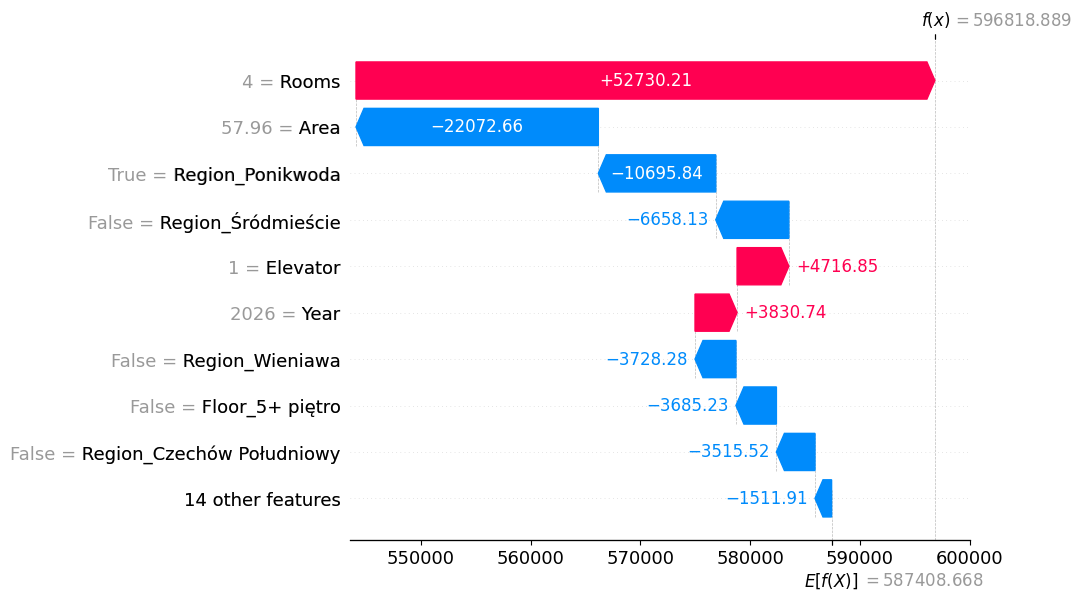

In [51]:
check_feature_importance(rf_model2, X_test_rf2,num_observations=1,random_seed=45)

This **feature importance plot** shows that **completely different features** play the biggest role in the model's decision, compared to previous observations. This confirms that **ML models function like a "black box"**, where feature contributions can vary significantly depending on the input, making interpretation complex and non-deterministic.

Now, let's handle the outliers in the dataset and remove them in case they significantly affect model performance.


### 4.4 Handling Outliers

---

**❗❗❗ Important Note: ❗❗❗**  

I researched different sources and found that **outliers can be handled either before or after splitting** the dataset. I choose to **handle them before splitting** to ensure consistency in preprocessing.  

At this stage, I don’t have a **clear goal to simply delete outliers**—instead, I want to **analyze, understand, and handle them properly** to gain deeper insights before deciding on further actions.

---

#### 4.4.1 Univariate Outlier Detection & Handling

To begin, I use the IQR method to identify outliers in Price, Area, Rooms, and Year.

In [52]:
# Columns to check for outliers
columns_to_check = ['Price', 'Area', 'Rooms', 'Year']

# Dictionary to store outlier counts
outlier_counts = {}

# Detect outliers for each column and count them
for col in columns_to_check:
    outliers = detect_outliers_iqr(data, col)
    outlier_counts[col] = len(outliers)
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in Price: 97
Outliers in Area: 94
Outliers in Rooms: 51
Outliers in Year: 40


IQR method identified such large number of outliers, as I explored in the EDA section this is apartament with very large area and number of rooms and removing them could lead to difficulties of the model to predict real estate of this type, so eliminating is not the best solution. Instead of that I will apply different treatments to each variable:
-  `Year` – Some extreme values. I will apply Winsorization (1%-99%) to cap extreme values while preserving most of the distribution.
- `Price` & `Area` – These variables have a right-skewed distribution. Instead of Winsorization. 
    - Since `Price` is the target variable, I will leave it unchanged, *as previous attempts at transformation and standardization resulted in worse metrics after inverse transformation.* 
    - For `Area`, I will apply a Box-Cox transformation to normalize its distribution, followed by standardization to ensure consistent scaling.
-  `Rooms` – For  linear/non-linear algorithms I will standardize it(like with other features). For tree-based models, I stay it unchanged and apply sample weighting to increase importance of houses with more rooms.

#### 4.4.2 Multivariate Outlier Detection & Handling

Unlike univariate methods, multivariate outlier detection identifies anomalous combinations of values

For this I will apply `DBSCAN` clustering to identify multivariate outliers in the dataset

Before using DBSCAN, let's choose best `eps` and `min_samples` parameters for the model. To do this, I will use the following discussion from StackOverflow: https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan/15063143#15063143

Note: As DBSCAN vulnerable to missing values and *I will impute the missing values after standardization with KNN Imputer*. I replace them with the median value for each column, this will not affect the main data because I do everything on a copy of the dataset.

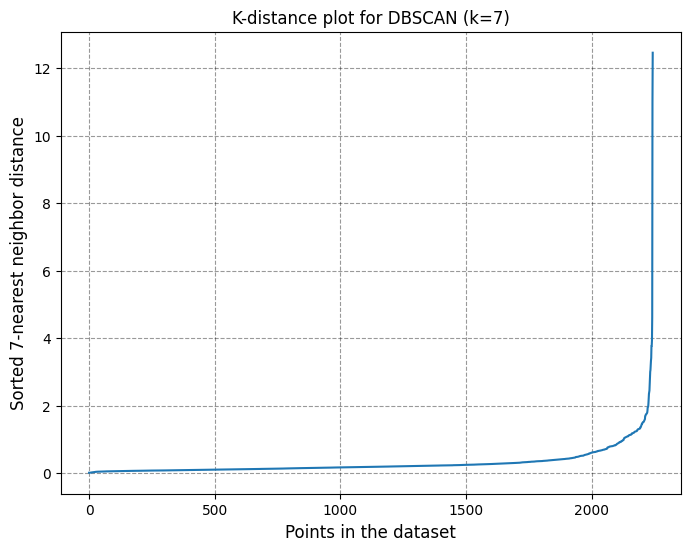

In [53]:
# Create a copy of the dataset
df_dbscan = data.copy()

# Select numerical features for DBSCAN
features_for_dbscan = ['Price', 'Area', 'Rooms', 'Year']

# Fill NaNs with the median value of each column
df_dbscan[features_for_dbscan] = df_dbscan[features_for_dbscan].fillna(df_dbscan[features_for_dbscan].median())

# Standardize the selected features (DBSCAN is sensitive to scale)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_dbscan[features_for_dbscan])

# Compute k-value using formula k = 2 * {dim(dataset)} - 1
k = 2 * scaled_features.shape[1] - 1  # k=2*number_of_features - 1

# Generate k-distance plot
get_kdist_plot(X=scaled_features, k=k)

From the plot, the optimal value for `eps` can be assumed at around 1.5

For `min_samples`, I will use general rule of thumb: `min_samples = 2 * number of features`, so in this case `min_samples = 2 * 4 = 8`

In [54]:
# Apply DBSCAN for outlier detection
dbscan = DBSCAN(eps=1.5, min_samples=8)  
df_dbscan['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_features)

In [55]:
# Count and display number of detected outliers
outlier_count = (df_dbscan['DBSCAN_Cluster'] == -1).sum()
print(f"Total DBSCAN Outliers Detected: {outlier_count}")

Total DBSCAN Outliers Detected: 19


In [56]:
# Display the detected outliers ordered by Year column
outliers_dbscan = df_dbscan[df_dbscan['DBSCAN_Cluster'] == -1].sort_values(by='Year')

# Add a column for price per square meter
outliers_dbscan['Price_per_sqm'] = outliers_dbscan['Price'] / outliers_dbscan['Area']

# Reorder columns to place 'Price_per_sqm' in the 3rd position
cols = outliers_dbscan.columns.tolist()
cols.insert(2, cols.pop(cols.index('Price_per_sqm')))
outliers_dbscan = outliers_dbscan[cols]

# Display the updated DataFrame
print(outliers_dbscan.to_string(index=False))

    Price       Area  Price_per_sqm  Elevator  Year  Rooms     Floor             Region  DBSCAN_Cluster
1256810.0  90.459999   13893.543945         0  1815      4  1 piętro        Śródmieście              -1
1256000.0  90.459999   13884.589844         0  1815      4  1 piętro        Śródmieście              -1
 428000.0 107.000000    4000.000000         0  1910      2  1 piętro          Dziesiąta              -1
1468000.0 125.750000   11673.956055         0  1910      5  2 piętro        Śródmieście              -1
1550000.0 128.800003   12034.161133         0  1914      4  3 piętro        Śródmieście              -1
1473000.0  98.199997   15000.000000         0  1914      4  1 piętro        Śródmieście              -1
 920000.0 140.000000    6571.428711         0  1918      5  4 piętro        Śródmieście              -1
 920000.0 126.000000    7301.587402         0  1918      7  4 piętro        Śródmieście              -1
1049000.0 126.000000    8325.396484         0  1927      4  1 pi

After analyzing the DBSCAN outliers, I identified the following key patterns:
- Mostly very old houses.
- Some houses with extremely low price per square meter
- Few apartments

Appartment with missing floor value, could be change similar to other apartments with 10 rooms on 1 piętro.

In [57]:
data.loc[(data['Region'] == 'Wieniawa') & (data['Price'] == 1940000.0), 'Floor'] = '1 piętro'

Additionally visualize them in 3D to see how far these points are from other data points in multidimensional space. This helps us understand the distribution and severity of anomalies in the dataset.

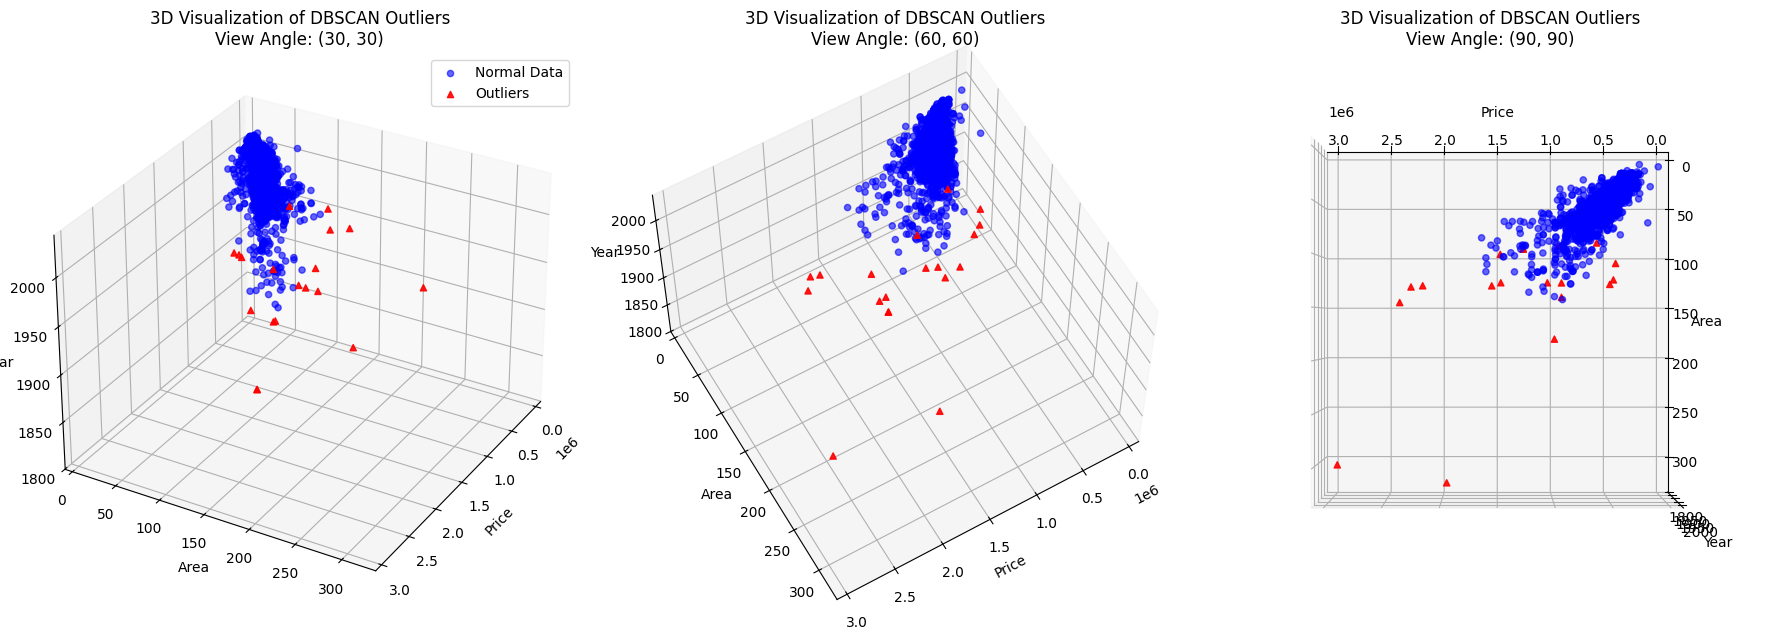

In [58]:
# Prepare Data for Visualization
fig = plt.figure(figsize=(18, 6))

# Extract normal points & outliers
normal_points = df_dbscan[df_dbscan['DBSCAN_Cluster'] != -1]
outlier_points = df_dbscan[df_dbscan['DBSCAN_Cluster'] == -1]

# Define angles for different views
angles = [(30, 30), (60, 60), (90, 90)]

for i, angle in enumerate(angles, 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    
    # Scatter plot
    ax.scatter(normal_points['Price'], normal_points['Area'], normal_points['Year'], c='blue', label='Normal Data', alpha=0.6)
    ax.scatter(outlier_points['Price'], outlier_points['Area'], outlier_points['Year'], c='red', label='Outliers', alpha=0.9, marker='^')
    
    # Labels & Legend
    ax.set_xlabel("Price")
    ax.set_ylabel("Area")
    ax.set_zlabel("Year")
    ax.set_title(f"3D Visualization of DBSCAN Outliers\nView Angle: {angle}")
    ax.view_init(elev=angle[0], azim=angle[1])
    if i == 1:
        ax.legend()

plt.tight_layout()
plt.show()

The 3D plot shows outliers, but since the dataset has more features, this view is limited. These few but extreme cases could mislead the model, and synthetic filling might add false patterns.

So I will try to build a Random Forest model with that outliers and SMOGN technique to handle imbalanced data. Then I evaluate the model performance and compare it with the previous version.

#### 4.4.3 Build RF model with SNOGN

Since SMOGN is sensitive to missing values, I'll impute them (median for numerical, mode for categorical), one-hot encode categorical variables, and scale numerical features. Then, I'll split the data, apply SMOGN to the training set to handle price outliers, and inverse transform the target variable. Finally, I'll tune hyperparameters with RandomizedSearchCV for optimal Random Forest performance and evaluate the model on the test set.

In [59]:
# Re-import necessary libraries after execution state reset
import pandas as pd
import smogn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Create a copy of the dataset for RF3 model
data_rf3 = data.copy()

# Handle missing values
data_rf3['Year'] = data_rf3['Year'].fillna(data_rf3['Year'].median())
data_rf3['Floor'] = data_rf3['Floor'].fillna(data_rf3['Floor'].mode()[0])  # Mode for categorical

# One-hot encode categorical features
data_rf3 = pd.get_dummies(data_rf3, columns=['Floor', 'Region'], drop_first=True, dtype='int32')

# Define features and target
features = data_rf3.drop('Price', axis=1)
target = data_rf3['Price']

# Create separate scalers
scaler_features = MinMaxScaler()
scaler_price = MinMaxScaler()

# Scale only numerical features except Price
num_features = ['Area', 'Year', 'Rooms']
features[num_features] = scaler_features.fit_transform(features[num_features])

# Scale Price separately
target_scaled = scaler_price.fit_transform(target.values.reshape(-1, 1)).flatten()

# Train-test split
X_train_rf3, X_test_rf3, y_train_rf3, y_test_rf3 = train_test_split(
    features, target_scaled, test_size=0.2, random_state=42
)

# Combine train features and target for SMOGN processing
train_rf3 = X_train_rf3.copy()
train_rf3['Price'] = y_train_rf3

# Reset index before applying SMOGN
train_rf3 = train_rf3.reset_index(drop=True)

# Ensure no missing values before SMOGN
train_rf3 = train_rf3.fillna(train_rf3.median())

# Apply SMOGN to the cleaned dataset
train_rf3_smogn = smogn.smoter(
    data=train_rf3,
    y='Price',
    pert=0.1,  # Adjust Gaussian noise level
    samp_method='balance'  # Use 'balance' instead of 'extreme' for better distribution
)

# Reset index again to avoid index mismatches
train_rf3_smogn = train_rf3_smogn.reset_index(drop=True)

# Separate features and target again after SMOGN
X_train_rf3_smogn = train_rf3_smogn.drop('Price', axis=1)
y_train_rf3_smogn = train_rf3_smogn['Price']

# Inverse transform Price using its own scaler
y_train_rf3_smogn = scaler_price.inverse_transform(y_train_rf3_smogn.values.reshape(-1, 1)).flatten()

# Define hyperparameter grid for Random Forest tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning
rf_grid = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    n_iter=10,
    n_jobs=-1
)

# Train the best Random Forest model found
rf_grid.fit(X_train_rf3_smogn, y_train_rf3_smogn)
best_rf_model = rf_grid.best_estimator_

# Predict on test set
y_pred_rf3 = best_rf_model.predict(X_test_rf3)

# Inverse transform y_test_rf3 before evaluation
y_test_rf3 = scaler_price.inverse_transform(y_test_rf3.reshape(-1, 1)).flatten()

# Evaluate the model
rf3_r2, rf3_mae, rf3_mse, rf3_rmse, rf3_mape, rf3_rmsle = evaluate_model(y_test_rf3, y_pred_rf3)
print(f"R^2: {rf3_r2:.4f}")
print(f"MAE: {rf3_mae:.2f}")       
print(f"RMSE: {rf3_rmse:.2f}")
print(f"MAPE: {rf3_mape:.2f}")
print(f"RMSLE: {rf3_rmsle:.4f}")

r_index: 100%|##########| 114/114 [00:00<00:00, 763.19it/s]


R^2: 0.7900
MAE: 59000.94
RMSE: 90840.59
MAPE: 9.90
RMSLE: 0.1277


Such harder and complex model with SMOGN technique and outliers handling, achieved worse results than the previous version model. So for future deeper analysis, I will write a copy of that dataset to a variable data_smogn and continue with the previous version of the dataset, by removing outliers.

In [60]:
data_smogn = data.copy(deep=True)

**Why Remove These Outliers?**
-  Small number of cases (only 19)
-  Synthetic filling (e.g., SMOGN) could introduce misleading data
-  Retaining them could bias the model
-  We already experimented with them and achieved worse results

Achieving worse results initially isn’t necessarily bad because the model is exposed to more diverse data and patterns, which can help it better generalize to extreme cases. This could lead to improved predictions on outliers or rare cases, which I plan to remove later. As my goal in this project is EXPERIMENT and find approaches to improve the model performance, using different techniques and methods, I will delete these outliers.

So delete that outliers from the main dataset.

In [61]:
# Identify outliers (DBSCAN-flagged as -1)
outlier_indices = df_dbscan[df_dbscan['DBSCAN_Cluster'] == -1].index

# Remove outliers from the main dataset
data = data.drop(index=outlier_indices)

Additionally let's once more check univariate outliers to verify if their number decreased.

In [62]:
# Columns to check for outliers
columns_to_check = ['Price', 'Area', 'Rooms', 'Year']

# Dictionary to store outlier counts
outlier_counts = {}

# Detect outliers for each column and count them
for col in columns_to_check:
    outliers = detect_outliers_iqr(data, col)
    outlier_counts[col] = len(outliers)
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in Price: 87
Outliers in Area: 80
Outliers in Rooms: 41
Outliers in Year: 36


Number of outliers decreased for each variable enough well, including the fact that I deleted only 19 observations.

### 4.5 Train-Test-Validation Split

As I will build various machine learning/deep learning models, I will split the dataset into training, validation, and test sets, I will use 70-15-15 split ratio. \
**It is very important to make split before any data transformation to avoid data leakage.**\
https://datascience.stackexchange.com/questions/53138/which-comes-first-multiple-imputation-splitting-into-train-test-or-standardiz
> Always split before you do any data pre-processing. Performing pre-processing before splitting will mean that information from your test set will be present during training, causing a data leak.

Additionally, some models require standardization, while others don't. 
- Linear models & Neural Networks: Require raw Price, Box-Cox transformation Area and standardization for numerical features.
- Tree-based models (Random Forest, XGBoost, etc.): Work best with raw Price, Box-Cox transformed Area, and unstandardized features.

In [63]:
# Create separate datasets for tree-based and linear models
data_tree = data.copy(deep=True)
data_linear = data.copy(deep=True)

# Define features (X) and target (y)
X_tree = data_tree.drop('Price', axis=1)
y_tree = data_tree['Price']

X_linear = data_linear.drop('Price', axis=1)
y_linear = data_linear['Price']

# Train-Test-Validation split (70-15-15 ratio)
X_train_tree, X_temp_tree, y_train_tree, y_temp_tree = train_test_split(
    X_tree, y_tree, test_size=0.3, random_state=42)

X_val_tree, X_test_tree, y_val_tree, y_test_tree = train_test_split(
    X_temp_tree, y_temp_tree, test_size=0.5, random_state=42)

X_train_linear, X_temp_linear, y_train_linear, y_temp_linear = train_test_split(
    X_linear, y_linear, test_size=0.3, random_state=42)

X_val_linear, X_test_linear, y_val_linear, y_test_linear = train_test_split(
    X_temp_linear, y_temp_linear, test_size=0.5, random_state=42)

# Display dataset sizes
split_summary = {
    "Dataset": ["Training", "Validation", "Test"],
    "Tree-Based (X)": [X_train_tree.shape[0], X_val_tree.shape[0], X_test_tree.shape[0]],
    "Tree-Based (y)": [y_train_tree.shape[0], y_val_tree.shape[0], y_test_tree.shape[0]],
    "Linear-Based (X)": [X_train_linear.shape[0], X_val_linear.shape[0], X_test_linear.shape[0]],
    "Linear-Based (y)": [y_train_linear.shape[0], y_val_linear.shape[0], y_test_linear.shape[0]]
}

split_summary

{'Dataset': ['Training', 'Validation', 'Test'],
 'Tree-Based (X)': [1556, 334, 334],
 'Tree-Based (y)': [1556, 334, 334],
 'Linear-Based (X)': [1556, 334, 334],
 'Linear-Based (y)': [1556, 334, 334]}

Train test validation split is done, now let's move to the next step.

### 4.6 Feature Transformation

#### 4.6.1 Tree Based Data Transformation

For tree-based models, I will apply the **Box-Cox transformation** to the `Area` feature to **normalize its distribution** and **winsorize the `Year` feature** to handle extreme values. Other transformations will be applied **specifically for each model**.  

At this stage, I **will not apply one-hot encoding**, as some algorithms (e.g., **CatBoost**) perform better with **label encoding**. Since I couldn't find conclusive research on which encoding works best for tree-based models, I will **experiment with both approaches** for some algorithms. 

Apply Box-Cox transformation to the `Area` feature. Of course, for validation and test sets, I will use the lambda value calculated on the training set.

In [64]:
# Copy datasets for transformation
X_train_tree_transformed = X_train_tree.copy()
X_val_tree_transformed = X_val_tree.copy()
X_test_tree_transformed = X_test_tree.copy()

# Apply Box-Cox transformation and store lambda
X_train_tree_transformed['Area'], area_lambda = stats.boxcox(X_train_tree_transformed['Area'])

# Apply the same lambda to validation and test sets
X_val_tree_transformed['Area'] = stats.boxcox(X_val_tree_transformed['Area'], lmbda=area_lambda)
X_test_tree_transformed['Area'] = stats.boxcox(X_test_tree_transformed['Area'], lmbda=area_lambda)

Additionally check the lambda area value

In [65]:
# Check transformation effect
print(f"Box-Cox Lambda for Area: {area_lambda}")

Box-Cox Lambda for Area: 0.009736520232480972


The **Box-Cox lambda (0.0097)** indicates a transformation close to log transformation

Let's check how changed the distribution of the `Area` feature after Box-Cox transformation.

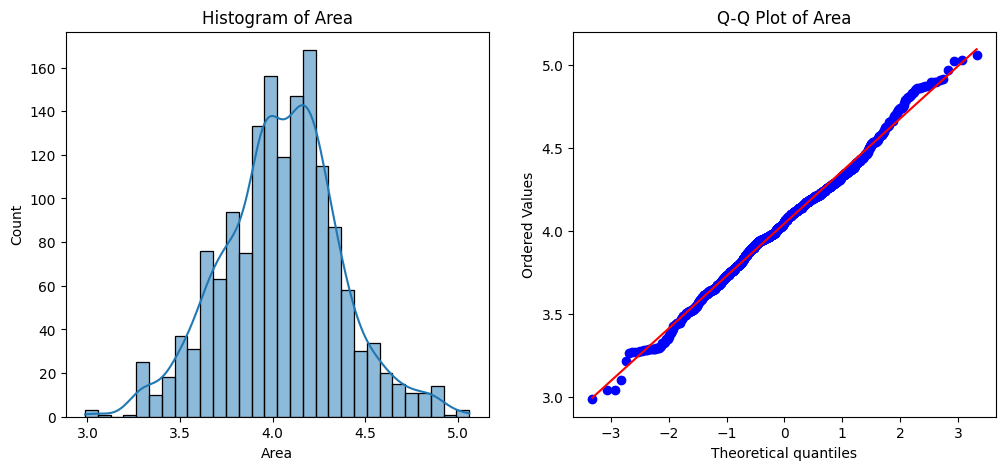

Normality Tests for Area:
  Shapiro-Wilk Test: W=0.9951, p-value=0.0001
  D'Agostino's K² Test: Stat=5.2042, p-value=0.0741
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Fail to reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


In [66]:
cols = ["Area"]
check_normality(X_train_tree_transformed, cols)

After the Box-Cox transformation, the `Area` feature exhibits a distribution closer to normality. The **Shapiro-Wilk test rejected the null hypothesis of normality**, while **D'Agostino's K² test failed to reject it**, suggesting improved normality. The **Q-Q plot shows that the transformed data points align more closely with the diagonal**, further indicating a more normally distributed feature.

Apply Winsorization to the `Year` feature.

I make a box plot of the `Year` column before and after winsorization.

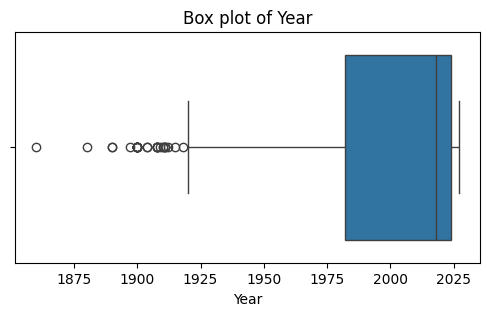

In [67]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=X_train_tree_transformed['Year'])
plt.title('Box plot of Year')
plt.xlabel('Year')
plt.show()

In [68]:
# Apply Winsorization to the training set and get limits
X_train_tree_transformed['Year'], year_lower, year_upper = winsorize_series(X_train_tree_transformed['Year'])

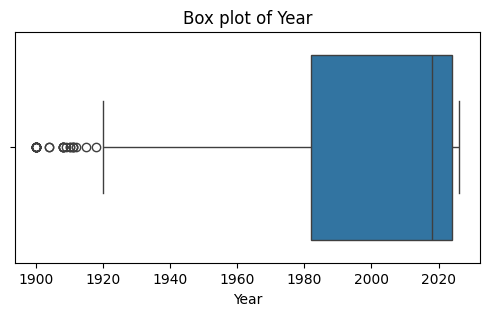

In [69]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=X_train_tree_transformed['Year'])
plt.title('Box plot of Year')
plt.xlabel('Year')
plt.show()

Winsorization made successfully.

This is also important to make Winsorization of test and validation sets and like with Box-Cox transformation, I will use the values calculated on the training set.
Source: https://stats.stackexchange.com/questions/350487/is-winsorization-performed-on-test-data-as-well
> it is common practice to apply Winsorization to test data as well.

> Before applying the model to test data, you have to apply Winsorization to test data as well (using the values saved from train data).

In [70]:
# Apply the same limits to validation and test sets
X_test_tree_transformed['Year'] = X_test_tree_transformed['Year'].clip(lower=year_lower, upper=year_upper).astype(X_test_tree_transformed['Year'].dtype)
X_val_tree_transformed['Year'] = X_val_tree_transformed['Year'].clip(lower=year_lower, upper=year_upper).astype(X_val_tree_transformed['Year'].dtype)

In this step I don't make standardization as I read [here](https://builtin.com/data-science/when-and-why-standardize-your-data)
> Algorithms such as decision trees, random forests and gradient boosting are not sensitive to the magnitude of variables. So standardization is not needed before fitting these kinds of models.

Of course the best way is to build few models and compare them, instead of always trust resources from the internet, because best model is the one that gives the best metrics.

#### 4.6.2 Linear Models Data Transformation

For linear models and Neural Networks, I will apply the following transformations:
- Box-Cox transformation to the `Area` feature to normalize its distribution.
- Winsorization to the `Year` feature to handle extreme values.
- Standardization to ensure consistent scaling across features.

Firstly make Box-Cox transformation to the `Area` feature.

In [71]:
# Copy datasets for transformation
X_train_linear_transformed = X_train_linear.copy()
X_val_linear_transformed = X_val_linear.copy()
X_test_linear_transformed = X_test_linear.copy()

# Apply Box-Cox transformation and store lambda
X_train_linear_transformed['Area'], area_lambda = stats.boxcox(X_train_linear_transformed['Area']) # Lambda will be the same as for tree-based

# Apply the same lambda to validation and test sets
X_val_linear_transformed['Area'] = stats.boxcox(X_val_linear_transformed['Area'], lmbda=area_lambda)
X_test_linear_transformed['Area'] = stats.boxcox(X_test_linear_transformed['Area'], lmbda=area_lambda)

Now apply Winsorization to the `Year` feature.

In [72]:
# Apply Winsorization to the training set and get limits
X_train_linear_transformed['Year'], year_lower, year_upper = winsorize_series(X_train_linear_transformed['Year'])

# Apply the same limits to validation and test sets
X_val_linear_transformed['Year'] = X_val_linear_transformed['Year'].clip(lower=year_lower, upper=year_upper).astype(X_val_linear_transformed['Year'].dtype)
X_test_linear_transformed['Year'] = X_test_linear_transformed['Year'].clip(lower=year_lower, upper=year_upper).astype(X_test_linear_transformed['Year'].dtype)

Now I will make standardization of the training set and then apply it to the validation and test sets.

Like with Box-Cox transformation and Winsorization, for standardization of test and validation sets, I will use the values calculated on the training set.

In [73]:
# Select numerical columns for standardization
num_cols = ['Area', 'Elevator', 'Year', 'Rooms']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_linear_transformed[num_cols] = scaler.fit_transform(X_train_linear_transformed[num_cols])

# Apply the same scaler to validation and test sets
X_val_linear_transformed[num_cols] = scaler.transform(X_val_linear_transformed[num_cols])
X_test_linear_transformed[num_cols] = scaler.transform(X_test_linear_transformed[num_cols])

Look on the dataset after transformations.

In [74]:
X_train_linear_transformed.head()

,Area,Elevator,Year,Rooms,Floor,Region
2217,-0.252426,-1.018160,NaN,0.359605,1 piętro,Czuby Północne
849,0.130607,0.982164,0.742415,0.359605,1 piętro,Wieniawa
2497,1.026662,0.982164,0.777270,1.532657,3 piętro,Ponikwoda
406,-2.203408,-1.018160,NaN,-1.986498,parter,Other
1769,1.407882,0.982164,0.289304,1.532657,3 piętro,Sławin


Good

Additionally I will make one-hot encoding for the categorical features, but as now Floor column contain missing values I will do this after imputation.

### 4.7 Handling Missing Values

I already wrote in 2.5 that that for missing values in `Year` and `Floor`, I will use a `KNN Imputer`, but after standardization, because KNN imputation requires standardization first due to how distance calculations work.

So now I could make KNN imputation for the `data_tree` and `data_linear` datasets.

#### 4.7.1 KNN Imputation for Tree-Based Models

Since **KNN Imputer** only works with numerical data, I will temporarily encode `Floor` as numbers, impute missing values, and then convert it back to its original categorical format.

As other transformation techniques to avoid data leakage I will use the imputer values calculated on the training set for validation and test sets. 

In [75]:
# Define the ordered mapping for Floor (assuming 'parter' is ground floor)
floor_mapping = {
    'parter': 0,
    '1 piętro': 1,
    '2 piętro': 2,
    '3 piętro': 3,
    '4 piętro': 4,
    '5+ piętro': 5,  
    np.nan: np.nan  # Keep NaNs for imputation
}

# Encode Floor using the defined mapping
X_train_tree_transformed['Floor'] = X_train_tree_transformed['Floor'].map(floor_mapping)
X_val_tree_transformed['Floor'] = X_val_tree_transformed['Floor'].map(floor_mapping)
X_test_tree_transformed['Floor'] = X_test_tree_transformed['Floor'].map(floor_mapping)

# Apply KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)

# Select numerical columns including Floor (but NOT Region)
num_cols = ['Area', 'Elevator', 'Year', 'Rooms', 'Floor']

# Fit on training data and transform
X_train_tree_transformed[num_cols] = knn_imputer.fit_transform(X_train_tree_transformed[num_cols])

# Apply the trained imputer to validation and test sets
X_val_tree_transformed[num_cols] = knn_imputer.transform(X_val_tree_transformed[num_cols])
X_test_tree_transformed[num_cols] = knn_imputer.transform(X_test_tree_transformed[num_cols])

# Round Floor values after imputation to ensure integers
X_train_tree_transformed['Floor'] = np.round(X_train_tree_transformed['Floor']).astype(int)
X_val_tree_transformed['Floor'] = np.round(X_val_tree_transformed['Floor']).astype(int)
X_test_tree_transformed['Floor'] = np.round(X_test_tree_transformed['Floor']).astype(int)

# Reverse map numerical values back to original categories
reverse_floor_mapping = {v: k for k, v in floor_mapping.items()}  # Swap keys and values

X_train_tree_transformed['Floor'] = X_train_tree_transformed['Floor'].map(reverse_floor_mapping)
X_val_tree_transformed['Floor'] = X_val_tree_transformed['Floor'].map(reverse_floor_mapping)
X_test_tree_transformed['Floor'] = X_test_tree_transformed['Floor'].map(reverse_floor_mapping)

To choose better `n_neighbors` value for KNN Imputer, I will build Random Forest model with different `n_neighbors` values and choose the best one. 


The best `n_neighbors` value is the one that gives the best model performance.

#### 4.7.2 Build Random Forest Model with KNN Imputation

In [76]:
X_train_tree_transformed_fr4 = X_train_tree_transformed.copy()

region_counts = X_train_tree_transformed_fr4['Region'].value_counts()
total_count = len(X_train_tree_transformed_fr4)
class_weights = {region: total_count / count for region, count in region_counts.items()}

# Create a new column to store sample weights before one-hot encoding
X_train_tree_transformed_fr4['Sample_Weight'] = X_train_tree_transformed_fr4['Region'].map(class_weights)

# One-hot encode 'Floor' and 'Region' columns
X_train_tree_transformed_fr4 = pd.get_dummies(X_train_tree_transformed_fr4, columns=['Floor', 'Region'], dtype='int32')

# Define features and target
features = X_train_tree_transformed_fr4.drop(['Sample_Weight'], axis=1)  # Exclude sample weight from features
target = y_train_tree
sample_weights = X_train_tree_transformed_fr4['Sample_Weight']  # Keep sample weights separate

# Initialize and train the Random Forest model with sample weights
rf_model4 = RandomForestRegressor(n_estimators=100, 
                                  random_state=42,
                                  max_features='sqrt')

rf_model4.fit(features, 
              target, 
              sample_weight=sample_weights)

# Prepare test set for prediction
X_test_tree_transformed_rf4 = X_test_tree_transformed.copy()
X_test_tree_transformed_rf4 = pd.get_dummies(X_test_tree_transformed_rf4, columns=['Floor', 'Region'], dtype='int32')

# Predict on test set
y_pred_rf4 = rf_model4.predict(X_test_tree_transformed_rf4)

# Evaluate the model
rf4_r2, rf4_mae, rf4_mse, rf4_rmse, rf4_mape, rf4_rmsle = evaluate_model(y_test_tree, y_pred_rf4)
print(f"R^2: {rf4_r2:.4f}")
print(f"MAE: {rf4_mae:.2f}")       
print(f"RMSE: {rf4_rmse:.2f}")
print(f"MAPE: {rf4_mape:.2f}")
print(f"RMSLE: {rf4_rmsle:.4f}")

R^2: 0.7986
MAE: 51465.50
RMSE: 77410.92
MAPE: 8.94
RMSLE: 0.1235


With default `n_neighbors = 5` model achieved the best results, so I will use this value for KNN Imputer. 

**After the transformations and imputation**, the following interesting situation can be observed in comparing with Random Forest model from `4.3`:
- R^2 decrease from 82% to 80%
- MAE increase from 50,000 to 51,500
- RMSE decrease from 83,500 to 77,500

From these results, we can conclude that the **model makes lighter mistakes** in larger price predictions while becoming slightly less precise overall.

#### 4.7.3 KNN Imputation for Linear Models

Like for tree-based models, I will impute missing values in the `data_linear` dataset using the KNN Imputer with `n_neighbors = 5`, as it gave the best results for the Random Forest model.

In [77]:
# Encode Floor using the defined mapping
X_train_linear_transformed['Floor'] = X_train_linear_transformed['Floor'].map(floor_mapping)
X_val_linear_transformed['Floor'] = X_val_linear_transformed['Floor'].map(floor_mapping)
X_test_linear_transformed['Floor'] = X_test_linear_transformed['Floor'].map(floor_mapping)

# Apply KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5) # Use 5 as before showed good results

# Select numerical columns including Floor (but NOT Region)
num_cols = ['Area', 'Elevator', 'Year', 'Rooms', 'Floor']

# Fit on training data and transform
X_train_linear_transformed[num_cols] = knn_imputer.fit_transform(X_train_linear_transformed[num_cols])

# Apply the trained imputer to validation and test sets
X_val_linear_transformed[num_cols] = knn_imputer.transform(X_val_linear_transformed[num_cols])
X_test_linear_transformed[num_cols] = knn_imputer.transform(X_test_linear_transformed[num_cols])

# Round Floor values after imputation to ensure integers
X_train_linear_transformed['Floor'] = np.round(X_train_linear_transformed['Floor']).astype(int)
X_val_linear_transformed['Floor'] = np.round(X_val_linear_transformed['Floor']).astype(int)
X_test_linear_transformed['Floor'] = np.round(X_test_linear_transformed['Floor']).astype(int)

# Reverse map numerical values back to original categories
reverse_floor_mapping = {v: k for k, v in floor_mapping.items()}  # Swap keys and values

X_train_linear_transformed['Floor'] = X_train_linear_transformed['Floor'].map(reverse_floor_mapping)
X_val_linear_transformed['Floor'] = X_val_linear_transformed['Floor'].map(reverse_floor_mapping)
X_test_linear_transformed['Floor'] = X_test_linear_transformed['Floor'].map(reverse_floor_mapping)

Since the data is now prepared, we can begin experimenting with different machine learning models and optimizing hyperparameters to select the best-performing model.

## 5. Build Machine Learning Models

I start from linear models as they 

### 5.1 Linear Regression

In [60]:
# Extract features and target
X = data_standardized.drop(columns=['Price'])  
y = data_standardized['Price'] 

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred = lr_model.predict(X_test)

# Evaluate the model
lr_r2, lr_mae, lr_mse, lr_rmse, lr_mape, lr_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {lr_r2:.4f}")
print(f"MAE: {lr_mae:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAPE: {lr_mape:.2f}")
print(f"RMSLE: {lr_rmsle:.4f}")

R^2: 0.7081
MAE: 69721.24
RMSE: 103943.41
MAPE: 11.97
RMSLE: 0.1684


Linear regression performed poorly due to the complex, non-linear relationships in the housing data, which it couldn't capture effectively.

### 5.2 Elastic Net Regression

Elastic Net improves upon Linear Regression by combining L1 (Lasso) and L2 (Ridge) regularization, which helps reduce overfitting, handle multicollinearity, and select important features.

Since its performance depends on alpha (regularization strength) and l1_ratio (balance between L1 and L2), I use GridSearchCV to find the best combination. 

In [ ]:
# Define a broader hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100],  
    'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1],
    'max_iter': [5000, 10000, 20000] 
}

# Initialize Elastic Net model
elastic_net = ElasticNet()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_elastic_net_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best Elastic Net Parameters:", best_params)

# Predict on test data
y_pred = best_elastic_net_model.predict(X_test)

# Evaluate the model
elastic_r2, elastic_mae, elastic_mse, elastic_rmse, elastic_mape, elastic_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {elastic_r2:.4f}")
print(f"MAE: {elastic_mae:.2f}")
print(f"RMSE: {elastic_rmse:.2f}")
print(f"MAPE: {elastic_mape:.2f}")
print(f"RMSLE: {elastic_rmsle:.4f}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Elastic Net Parameters: {'alpha': 0.1, 'l1_ratio': 0.7, 'max_iter': 5000}
R^2: 0.6935
MAE: 70146.99
RMSE: 106518.13
MAPE: 11.83
RMSLE: 0.1616


**Elastic Net regression** performed worse than expected, likely due to the non-linear relationships in the data that it couldn't fully capture. So let's try more complex models.

### 5.3 Support Vector Regression

Now let's try **Support Vector Regression (SVR)**, which can capture complex relationships in the data and handle non-linear patterns.

In [ ]:
# Define hyperparameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}

# Initialize SVR model
svr = SVR()

# Perform Grid Search with Cross-Validation 
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_svr_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best SVR Parameters:", best_params)

# Predict on test data
y_pred = best_svr_model.predict(X_test)

# Evaluate the model
svr_r2, svr_mae, svr_mse, svr_rmse, svr_mape, svr_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {svr_r2:.4f}")
print(f"MAE: {svr_mae:.2f}")
print(f"RMSE: {svr_rmse:.2f}")
print(f"MAPE: {svr_mape:.2f}")
print(f"RMSLE: {svr_rmsle:.4f}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best SVR Parameters: {'C': 1000, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
R^2: 0.6348
MAE: 69616.68
RMSE: 116273.44
MAPE: 11.15
RMSLE: 0.1595


**Support Vector Regression (SVR)** performed worse than **Linear and Elastic Net Regression**, struggling to capture the complex relationships in the data. So, let's try tree-based models to better handle non-linearity and feature interactions.

### 5.4 Decision Tree Regressor

I will train a **Decision Tree Regressor** while improving model fairness by applying sample weighting to `Region`, `Floor`, and `Rooms`. Then, I will tune hyperparameters using GridSearchCV for better performance. 

In [66]:
# Label encode categorical features 
label_encoder_floor = LabelEncoder()
label_encoder_region = LabelEncoder()

data_tree['Floor'] = label_encoder_floor.fit_transform(data_tree['Floor'])
data_tree['Region'] = label_encoder_region.fit_transform(data_tree['Region'])

# Compute weights for Region, Floor, and Rooms
region_weights = compute_weights(data_tree, 'Region')
floor_weights = compute_weights(data_tree, 'Floor')
room_weights = compute_weights(data_tree, 'Rooms') 

# Map weights to each sample
data_tree['region_weight'] = data_tree['Region'].map(region_weights)
data_tree['floor_weight'] = data_tree['Floor'].map(floor_weights)
data_tree['room_weight'] = data_tree['Rooms'].map(room_weights)

# Combine weights (average or product method)
data_tree['sample_weight'] = (data_tree['region_weight'] + data_tree['floor_weight'] + data_tree['room_weight']) / 3  # Averaging method

# Define features and target
features = data_tree.drop(columns=['Price', 'region_weight', 'floor_weight', 'room_weight', 'sample_weight'])  # Exclude weight columns
target = data_tree['Price']

# Split data with weights
X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
    features, target, data_tree['sample_weight'], test_size=0.2, random_state=42
)

In [ ]:
# Expanded hyperparameter grid for better optimization
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
    'splitter': ['best', 'random'], 
    'max_depth': [5, 10, 15, 20, None],  
    'min_samples_split': [2, 5, 10, 20],  
    'min_samples_leaf': [1, 2, 5, 10], 
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05], 
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1] 
}

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(dt_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train, sample_weight=train_weights) 

# Get the best model and parameters
best_dt_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best Decision Tree Parameters:", best_params)

# Predict on test data
y_pred = best_dt_model.predict(X_test)
# Evaluate the model
dt_r2, dt_mae, dt_mse, dt_rmse, dt_mape, dt_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {dt_r2:.4f}")
print(f"MAE: {dt_mae:.2f}")
print(f"RMSE: {dt_rmse:.2f}")
print(f"MAPE: {dt_mape:.2f}")
print(f"RMSLE: {dt_rmsle:.4f}")

Fitting 5 folds for each of 23040 candidates, totalling 115200 fits
Best Decision Tree Parameters: {'ccp_alpha': 0.0, 'criterion': 'poisson', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
R^2: 0.7292
MAE: 52319.71
RMSE: 100119.68
MAPE: 8.89
RMSLE: 0.1474


The **Decision Tree Regressor** performed better than previous models, but there is still room for improvement. To achieve higher accuracy, I will now try more advanced models like Random Forest and Boosting algorithms

### 5.5 Random Forest Regressor

Now, I build again a **Random Forest Regressor**, with weighted samples and hyperparameter tuning to improve performance.

In [67]:
# Expanded hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500], 
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5], 
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False] 
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Grid Search with Cross-Validation 
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train, sample_weight=train_weights) 

# Get the best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best Random Forest Parameters:", best_params)

# Predict on test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
rf_r2, rf_mae, rf_mse, rf_rmse, rf_mape, rf_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {rf_r2:.4f}")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAPE: {rf_mape:.2f}")
print(f"RMSLE: {rf_rmsle:.4f}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
R^2: 0.8598
MAE: 39927.44
RMSE: 72041.99
MAPE: 6.86
RMSLE: 0.1100


Compared to the previous Random Forest model, the new model showed a lower $R^2$ but improved **MAE**, **MAPE**, and **RMSLE**, indicating overall better prediction accuracy. However, the higher **RMSE** suggests the presence of a few large errors, likely due to some extreme incorrect predictions.

In [186]:
# Select categorical features to encode
categorical_features = ['Floor', 'Region']

# Apply One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_categorical = one_hot_encoder.fit_transform(data_tree[categorical_features])

# Convert encoded features to DataFrame
encoded_df = pd.DataFrame(encoded_categorical, columns=one_hot_encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns and merge with encoded features
data_tree = data_tree.drop(columns=categorical_features).reset_index(drop=True)
data_tree = pd.concat([data_tree, encoded_df], axis=1)

# Adjust weight computation for encoded features
region_columns = [col for col in data_tree.columns if col.startswith('Region_')]
floor_columns = [col for col in data_tree.columns if col.startswith('Floor_')]

# Compute weight sums for categorical features
data_tree['region_weight'] = data_tree[region_columns].sum(axis=1)
data_tree['floor_weight'] = data_tree[floor_columns].sum(axis=1)
data_tree['room_weight'] = data_tree['Rooms'].map(compute_weights(data_tree, 'Rooms'))

# Combine weights (average method)
data_tree['sample_weight'] = (data_tree['region_weight'] + data_tree['floor_weight'] + data_tree['room_weight']) / 3

# Define features and target
features = data_tree.drop(columns=['Price', 'region_weight', 'floor_weight', 'room_weight', 'sample_weight'])
target = data_tree['Price']

# Split data with weights
X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
    features, target, data_tree['sample_weight'], test_size=0.2, random_state=42
)

# Expanded hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500], 
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5], 
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False] 
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Grid Search with Cross-Validation 
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train, sample_weight=train_weights) 

# Get the best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best Random Forest Parameters:", best_params)

# Predict on test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
rf_r2, rf_mae, rf_mse, rf_rmse, rf_mape, rf_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {rf_r2:.4f}")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAPE: {rf_mape:.2f}")
print(f"RMSLE: {rf_rmsle:.4f}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
R^2: 0.8611
MAE: 38909.47
RMSE: 71712.31
MAPE: 6.85
RMSLE: 0.1117


Now, I will build boosting algorithms, which can handle complex relationships, reduce bias, and improve accuracy by combining multiple weak models into a strong one. 

### 5.6 Gradient Boosting Regressor

Now I will build boosting algorithms, as they work better with one-hot encoded categorical features, I will create **data_boosting** dataset with one-hot encoding for categorical features.

In [67]:
# One-hot encode categorical features
data_boosting = pd.get_dummies(data_tree, columns=['Floor', 'Region'], drop_first=True, dtype=int)

# Define features and target
X = data_boosting.drop(columns=['Price'])
y = data_boosting['Price']  

# Split data (without sample weights)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I will train a **Gradient Boosting Regressor (GBR)** using one-hot encoding for categorical features (`Floor`, `Region`) because GBR does not natively handle categorical variables. One-hot encoding allows the model to learn without assuming ordinal relationships. Then, I will optimize hyperparameters using GridSearchCV to improve performance.

In [68]:
# Define a lighter hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300],  
    'learning_rate': [0.01, 0.1], 
    'max_depth': [3, 7],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'subsample': [0.7, 1.0],  
    'max_features': ['sqrt', None] 
}

# Initialize Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)  

# Get the best model and parameters
best_gbr_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best GBR Parameters:", best_params)

# Predict on test data
y_pred = best_gbr_model.predict(X_test)

# Evaluate the model
gbr_r2, gbr_mae, gbr_mse, gbr_rmse, gbr_mape, gbr_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {gbr_r2:.4f}")
print(f"MAE: {gbr_mae:.2f}")
print(f"RMSE: {gbr_rmse:.2f}")
print(f"MAPE: {gbr_mape:.2f}")
print(f"RMSLE: {gbr_rmsle:.4f}")

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best GBR Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.7}
R^2: 0.8530
MAE: 40550.43
RMSE: 73777.39
MAPE: 6.98
RMSLE: 0.1137


The Gradient Boosting Regressor (GBR) without sample weighting showed slightly worse results compared to the Random Forest model. 

### 5.7 XGBoost Regressor

In [69]:
# Define a lighter hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300], 
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 7], 
    'min_child_weight': [1, 5],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.7, 1.0], 
    'gamma': [0, 0.1],  
    'reg_alpha': [0, 0.1], 
    'reg_lambda': [1, 10] 
}

# Initialize XGBoost Regressor
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform Grid Search with Cross-Validation 
grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best XGBoost Parameters:", best_params)

# Predict on test data
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
xgb_r2, xgb_mae, xgb_mse, xgb_rmse, xgb_mape, xgb_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {xgb_r2:.4f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAPE: {xgb_mape:.2f}")
print(f"RMSLE: {xgb_rmsle:.4f}")

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best XGBoost Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}
R^2: 0.8533
MAE: 41494.26
RMSE: 73683.25
MAPE: 7.10
RMSLE: 0.1124


XGBoost showed similar results to the Gradient Boosting Regressor, with a slightly lower $R^2$ score. Now additionally let's try LightGBM.

### 5.8 LightGBM Regressor

LightGBM more often used for large datasets, but instead of that I will try it on this dataset to check if it will perform better than previous models.

In [70]:
# Define a hyperparameter grid
param_grid = {
    'n_estimators': [100, 300],  
    'learning_rate': [0.05, 0.1],  
    'max_depth': [5, 10], 
    'num_leaves': [20, 31, 50],
    'min_child_samples': [10, 20],
    'subsample': [0.8, 1.0], 
    'colsample_bytree': [0.8, 1.0]
}

# Initialize LightGBM Regressor with logging disabled
lgb_regressor = lgb.LGBMRegressor(random_state=42, verbose=-1)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(lgb_regressor, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

# Restore stderr to normal
sys.stderr = sys.__stderr__

# Get the best model and parameters
best_lgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best LightGBM Parameters:", best_params)

# Predict on test data
y_pred = best_lgb_model.predict(X_test)

# Evaluate the model
lgb_r2, lgb_mae, lgb_mse, lgb_rmse, lgb_mape, lgb_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {lgb_r2:.4f}")
print(f"MAE: {lgb_mae:.2f}")
print(f"RMSE: {lgb_rmse:.2f}")
print(f"MAPE: {lgb_mape:.2f}")
print(f"RMSLE: {lgb_rmsle:.4f}")

  File "c:\Users\davyd\miniconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\davyd\miniconda3\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\davyd\miniconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\davyd\miniconda3\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Best LightGBM Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 50, 'subsample': 0.8}
R^2: 0.8505
MAE: 43372.12
RMSE: 74393.43
MAPE: 7.47
RMSLE: 0.1160


LightGBM showed few worse results than XGBoost, but still better than Random Forest.

### 5.9 CatBoost Regressor

**CatBoost** is different from **LightGBM** and **XGBoost** because it natively supports categorical features, so there is no need to one-hot encode them. 

This algorithm works good with categorical features, so let's try it on the our dataset.

In [ ]:
# Define categorical features 
cat_features = ['Floor', 'Region']

# Define features and target
X = data_tree.drop(columns=['Price']) 
y = data_tree['Price']  

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a hyperparameter grid for CatBoost
param_grid = {
    'iterations': [1000], # [500, 1000]
    'learning_rate': [0.1], # [0.05, 0.1]
    'depth': [6], # [6, 10]
    'l2_leaf_reg': [3], # [3, 10]
    'bagging_temperature': [0.5], # [0.5, 1.0]
    'random_strength': [1]  # [1, 5]
}

# Initialize CatBoost Regressor with categorical feature support
catboost_regressor = CatBoostRegressor(cat_features=cat_features, random_state=42, verbose=0)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(catboost_regressor, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

# Restore stderr to normal
sys.stderr = sys.__stderr__

# Get the best model and parameters
best_catboost_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best CatBoost Parameters:", best_params)

# Predict on test data
y_pred = best_catboost_model.predict(X_test)

# Evaluate the model
catboost_r2, catboost_mae, catboost_mse, catboost_rmse, catboost_mape, catboost_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {catboost_r2:.4f}")
print(f"MAE: {catboost_mae:.2f}")
print(f"RMSE: {catboost_rmse:.2f}")
print(f"MAPE: {catboost_mape:.2f}")
print(f"RMSLE: {catboost_rmsle:.4f}")

Best CatBoost Parameters: {'bagging_temperature': 0.5, 'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'random_strength': 1}
R^2: 0.8493
MAE: 46745.21
RMSE: 74690.54
MAPE: 8.00
RMSLE: 0.1136


**CatBoost** did not perform as well as expected, showing slightly worse results compared to other boosting algorithms (**Gradient Boosting** ,**XGBoost**, **LightGBM**) and **Random Forest**.

### 5.10 Model Comparison

Finally let's compare all models to choose which showed the best results.

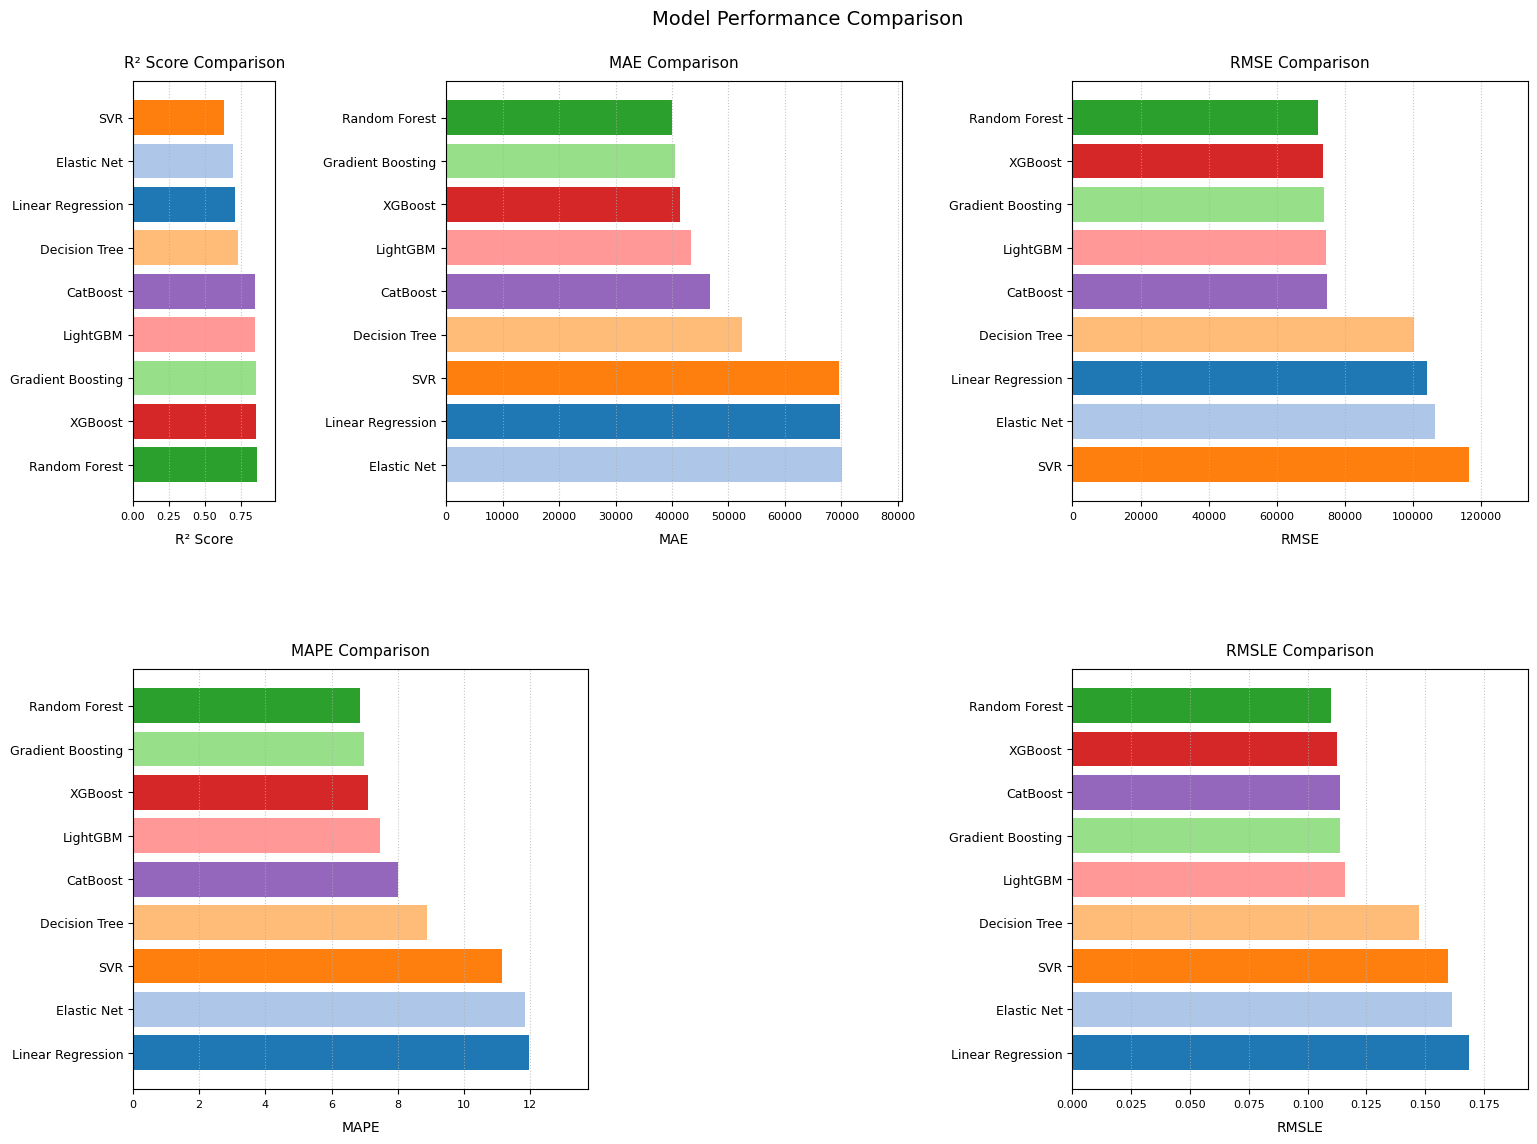

In [ ]:
# Define metric values for each model
r2_scores = {
    "Linear Regression": lr_r2,
    "Elastic Net": elastic_r2,
    "SVR": svr_r2,
    "Decision Tree": dt_r2,
    "Random Forest": rf_r2,
    "Gradient Boosting": gbr_r2,
    "XGBoost": xgb_r2,
    "LightGBM": lgb_r2,
    "CatBoost": catboost_r2
}

mae_scores = {
    "Linear Regression": lr_mae,
    "Elastic Net": elastic_mae,
    "SVR": svr_mae,
    "Decision Tree": dt_mae,
    "Random Forest": rf_mae,
    "Gradient Boosting": gbr_mae,
    "XGBoost": xgb_mae,
    "LightGBM": lgb_mae,
    "CatBoost": catboost_mae
}

rmse_scores = {
    "Linear Regression": lr_rmse,
    "Elastic Net": elastic_rmse,
    "SVR": svr_rmse,
    "Decision Tree": dt_rmse,
    "Random Forest": rf_rmse,
    "Gradient Boosting": gbr_rmse,
    "XGBoost": xgb_rmse,
    "LightGBM": lgb_rmse,
    "CatBoost": catboost_rmse
}

mape_scores = {
    "Linear Regression": lr_mape,
    "Elastic Net": elastic_mape,
    "SVR": svr_mape,
    "Decision Tree": dt_mape,
    "Random Forest": rf_mape,
    "Gradient Boosting": gbr_mape,
    "XGBoost": xgb_mape,
    "LightGBM": lgb_mape,
    "CatBoost": catboost_mape
}

rmsle_scores = {
    "Linear Regression": lr_rmsle,
    "Elastic Net": elastic_rmsle,
    "SVR": svr_rmsle,
    "Decision Tree": dt_rmsle,
    "Random Forest": rf_rmsle,
    "Gradient Boosting": gbr_rmsle,
    "XGBoost": xgb_rmsle,
    "LightGBM": lgb_rmsle,
    "CatBoost": catboost_rmsle
}

# Generate model colors using a colormap
models = list(r2_scores.keys())
cmap = plt.get_cmap('tab20')  # Using a colormap with enough colors
model_colors = {model: cmap(i) for i, model in enumerate(models)}

# Create figure with enhanced GridSpec configuration
fig = plt.figure(figsize=(18, 12)) 
gs = gridspec.GridSpec(2, 5, width_ratios=[1,1,1,1,1], wspace=1.2, hspace=0.4)

# Top row assignments
ax0 = plt.subplot(gs[0, 0])  
ax1 = plt.subplot(gs[0, 1:3])  
ax2 = plt.subplot(gs[0, 3:5])   

# Bottom row - centered plots
ax3 = plt.subplot(gs[1, 0:2])  
ax4 = plt.subplot(gs[1, 3:5]) 

# Configure all axes
for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='y', labelsize=9) 
    ax.xaxis.set_tick_params(labelsize=8)  

# Plotting function with label adjustments
def plot_metric(ax, metric_name, metric_values):
    sorted_metrics = dict(sorted(metric_values.items(), 
                               key=lambda item: item[1], 
                               reverse=True))
    colors = [model_colors[model] for model in sorted_metrics.keys()]
    
    bars = ax.barh(list(sorted_metrics.keys()), 
                 list(sorted_metrics.values()), 
                 color=colors)
    
    ax.set_title(f"{metric_name} Comparison", fontsize=11, pad=10)
    ax.set_xlabel(metric_name, fontsize=10, labelpad=8)
    ax.grid(axis='x', linestyle=':', alpha=0.7)
    
    # Set dynamic x-lim padding
    xmax = max(metric_values.values())
    ax.set_xlim(left=0, right=xmax * 1.15) 

# Plot all metrics
metrics_data = [
    (ax0, "R² Score", r2_scores),
    (ax1, "MAE", mae_scores),
    (ax2, "RMSE", rmse_scores),
    (ax3, "MAPE", mape_scores),
    (ax4, "RMSLE", rmsle_scores)
]

for ax, name, values in metrics_data:
    plot_metric(ax, name, values)

# Final layout adjustments
plt.subplots_adjust(top=0.92, bottom=0.08)
plt.suptitle("Model Performance Comparison", fontsize=14)
plt.show()

Among all tested models, **Random Forest** demonstrated the best overall performance across all metrics, making it the most effective model for predicting house prices. Following **Random Forest**, **Gradient Boosting** and **XGBoost** delivered comparable results, performing well but slightly behind. Now, let's try **deep learning models**, to see if they can further improve predictions. 

### 5.11 Stacking Model

As Random Forest, Gradient Boosting, and XGBoost performed well, I will combine them into a **Stacking Regressor** to leverage their strengths and improve overall performance.

In [114]:
# Define optimized base models
base_models = [
    ("RandomForest", RandomForestRegressor(
        n_estimators=1000, max_depth=50, max_features="sqrt", min_samples_leaf=1,
        min_samples_split=2, bootstrap=False, random_state=42, n_jobs=-1)),
    
    ("GradientBoosting", GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=7, max_features=None,
        min_samples_leaf=1, min_samples_split=2, subsample=0.7, random_state=42)),
    
    ("XGBoost", XGBRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=7, colsample_bytree=1.0,
        gamma=0, min_child_weight=1, reg_alpha=0, reg_lambda=1, subsample=0.7,
        random_state=42, n_jobs=-1))
]

# Define meta-learner
meta_learner = LinearRegression()

# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_learner, n_jobs=-1)

# Train the stacking model with sample weights
stacking_model.fit(X_train, y_train, sample_weight=train_weights)

# Make predictions on the test set
y_pred = stacking_model.predict(X_test)

# Evaluate the Stacking Model
stack_r2 = r2_score(y_test, y_pred)
stack_mae = mean_absolute_error(y_test, y_pred)
stack_mse = mean_squared_error(y_test, y_pred)
stack_rmse = np.sqrt(stack_mse)
stack_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
stack_rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))

# Print evaluation results
print(f"R²: {stack_r2:.4f}")
print(f"MAE: {stack_mae:.2f}")
print(f"RMSE: {stack_rmse:.2f}")
print(f"MAPE: {stack_mape:.2f}")
print(f"RMSLE: {stack_rmsle:.4f}")

R²: 0.8603
MAE: 40121.68
RMSE: 71913.06
MAPE: 6.85
RMSLE: 0.1090


The **Stacking Model** performed almost identically to **Random Forest**, with very slight improvements in some metrics. While **R², RMSE, and RMSLE** showed minor improvements, **MAE** slightly increased.

Since the results are *very close*, **Random Forest** remains a strong choice due to its simplicity and efficiency compared to the more complex stacking approach. 

## 6. Build Deep Learning Models

I will start by building a **Feedforward Neural Network (FNN)** using `data_standardized`, because neural networks train better with normalized inputs. After evaluating its performance, I will experiment with other architectures like **CNNs** and **RNNs** to see if they can further improve accuracy.

### 6.1 Feedforward Neural Network

The model has four hidden layers (256-128-64-32 neurons) with *ReLU* activations, batch normalization, and dropout to prevent *overfitting*. I use *RMSE* as the loss function since it penalizes large errors more effectively than *MAE*, addressing issues from previous models where *RMSE* was higher than *MAE*. Additionally, I create a validation set to monitor training performance and penalize the model if it *overfits*.



Prepare data for deep learning models by splitting it into training and validation sets.

In [147]:
# Convert dataset to PyTorch tensors
X = torch.tensor(data_standardized.drop(columns=['Price']).values, dtype=torch.float32)
y = torch.tensor(data_standardized['Price'].values, dtype=torch.float32).view(-1, 1)  

# Split data into train, validation & test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

Epoch [100/1000] | Train Loss: 83182.8705, Train RMSE: 74423.10 | Val Loss: 95102.1797, Val RMSE: 95102.18
Epoch [200/1000] | Train Loss: 73989.5341, Train RMSE: 65045.04 | Val Loss: 88807.7031, Val RMSE: 88807.70
Epoch [300/1000] | Train Loss: 73845.0334, Train RMSE: 61464.06 | Val Loss: 92971.5391, Val RMSE: 92971.54
Epoch [400/1000] | Train Loss: 70818.9126, Train RMSE: 60323.53 | Val Loss: 94193.9453, Val RMSE: 94193.95
Epoch [500/1000] | Train Loss: 70769.9899, Train RMSE: 57450.13 | Val Loss: 92357.5625, Val RMSE: 92357.56
Epoch [600/1000] | Train Loss: 68163.8286, Train RMSE: 58960.19 | Val Loss: 89682.0703, Val RMSE: 89682.07
Epoch [700/1000] | Train Loss: 67424.0067, Train RMSE: 55943.99 | Val Loss: 90037.7734, Val RMSE: 90037.77
Epoch [800/1000] | Train Loss: 66424.7505, Train RMSE: 56823.83 | Val Loss: 91487.9766, Val RMSE: 91487.98
Epoch [900/1000] | Train Loss: 69530.6888, Train RMSE: 54557.94 | Val Loss: 93262.2266, Val RMSE: 93262.23
Epoch [1000/1000] | Train Loss: 65661

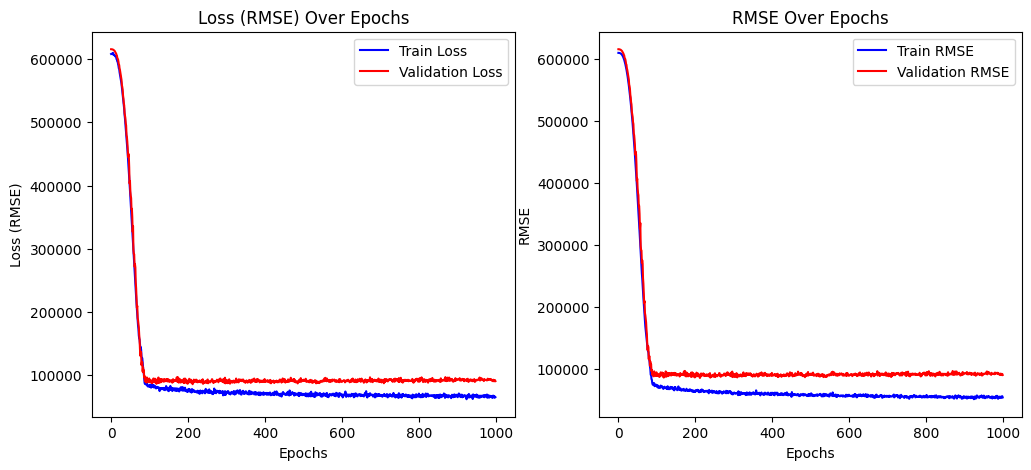

R^2: 0.8415
MAE: 49442.38
RMSE: 77717.38
MAPE: 8.37
RMSLE: 0.1216


In [148]:
# Define a Neural Network
class HousePriceNN(nn.Module):
    def __init__(self, input_size):
        super(HousePriceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, RMSE loss function & optimizer
input_size = X_train.shape[1]
model = HousePriceNN(input_size)

def RMSELoss(y_pred, y_true):
    return torch.sqrt(nn.MSELoss()(y_pred, y_true))  # RMSE Loss function

criterion = RMSELoss  # Using RMSE loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation monitoring
epochs = 1000
batch_size = 32
train_losses, val_losses, train_rmse, val_rmse = [], [], [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))  # Shuffle data

    batch_train_losses = []
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_train_losses.append(loss.item())

    # Compute training loss & RMSE
    train_loss = np.mean(batch_train_losses)
    with torch.no_grad():
        y_train_pred = model(X_train)
        train_rmse_value = torch.sqrt(nn.MSELoss()(y_train_pred, y_train)).item()

    # Compute validation loss & RMSE
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val).item()
        val_rmse_value = torch.sqrt(nn.MSELoss()(y_val_pred, y_val)).item()

    # Store results for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_rmse.append(train_rmse_value)
    val_rmse.append(val_rmse_value)

    # Print progress every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse_value:.2f} | Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse_value:.2f}")

# Plot loss & RMSE curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(epochs), train_losses, label="Train Loss", color="blue")
axes[0].plot(range(epochs), val_losses, label="Validation Loss", color="red")
axes[0].set_title("Loss (RMSE) Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss (RMSE)")
axes[0].legend()

axes[1].plot(range(epochs), train_rmse, label="Train RMSE", color="blue")
axes[1].plot(range(epochs), val_rmse, label="Validation RMSE", color="red")
axes[1].set_title("RMSE Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("RMSE")
axes[1].legend()

plt.show()

# Model evaluation on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()
    y_test_np = y_test.numpy().flatten()

# Compute metrics
fnn1_r2, fnn1_mae, fnn1_mse, fnn1_rmse, fnn1_mape, fnn1_rmsle = evaluate_model(y_test_np, y_pred)

# Print results
print(f"R^2: {fnn1_r2:.4f}")
print(f"MAE: {fnn1_mae:.2f}")
print(f"RMSE: {fnn1_rmse:.2f}")
print(f"MAPE: {fnn1_mape:.2f}")
print(f"RMSLE: {fnn1_rmsle:.4f}")

The **FNN** did not outperform traditional **ML models**, showing worse results compared to **Random Forest** and some **boosting algorithms**. After 150 epochs, the validation loss stopped improving while the training loss continued to decrease, indicating that the model couldn't fully learn certain patterns in the data. The gap between training and validation loss suggests overfitting, so it is necessary to decrease number of epochs or use **early stopping** to prevent overfitting.

### 6.2 FNN with SMOGN & RMSLE Loss

After training the default FNN model, I will experiment with several modifications to see if they improve performance:
- Apply SMOGN to handle data imbalance and stabilize predictions.
- Reduce batch size (8) and number of epochs (300) 
- Use RMSLE as the loss function to penalize large errors more effectively.

**Why RMSLE loss function?**

The **Root Mean Squared Logarithmic Error (RMSLE)** is defined as:  

$$RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(y_{\text{pred}} + 1) - \log(y_{\text{true}} + 1) \right)^2}$$

✅ **Penalizes underestimation more than overestimation**, which is crucial in house price prediction.  
✅ **Commonly used in real estate models** because it helps avoid significantly underpricing expensive properties.  
✅ **More stable on skewed price distributions**, making it ideal for this problem.

Prepare SMOGN data with one-hot encoding and train/test/validation split.

In [ ]:
data_standardized_copy = data_standardized.copy(deep=True)

# Convert one-hot encoded 'Floor' back to a single categorical variable
data_standardized_copy['Floor'] = data_standardized_copy[['Floor_2 piętro', 'Floor_3 piętro', 'Floor_4 piętro',
                                                'Floor_5+ piętro', 'Floor_parter']].idxmax(axis=1)

# Convert one-hot encoded 'Region' back to a single categorical variable
region_columns = [col for col in data_standardized_copy.columns if col.startswith("Region_")]
data_standardized_copy['Region'] = data_standardized_copy[region_columns].idxmax(axis=1)

# Drop the old one-hot encoded columns
data_standardized_copy.drop(columns=region_columns + ['Floor_2 piętro', 'Floor_3 piętro', 'Floor_4 piętro',
                                                 'Floor_5+ piętro', 'Floor_parter'], inplace=True)

# Reset index before applying SMOGN
data_standardized_copy.reset_index(drop=True, inplace=True)

# Apply SMOGN to balance the dataset
data_smogn = smoter(data_standardized_copy, y='Price')

# Apply One-Hot Encoding again to `data_smogn`
data_smogn = pd.get_dummies(data_smogn, columns=['Floor', 'Region'], drop_first=True, dtype=int)

# Convert dataset to PyTorch tensors
X = torch.tensor(data_smogn.drop(columns=['Price']).values, dtype=torch.float32)
y = torch.tensor(data_smogn['Price'].values, dtype=torch.float32).view(-1, 1)  # Reshape for PyTorch

# Split data into train, validation & test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% Train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% Val, 15% Test

Epoch [50/300] | Train Loss: 0.2213, Train RMSE: 148737.56 | Val Loss: 0.1793, Val RMSE: 145308.16
Epoch [100/300] | Train Loss: 0.2013, Train RMSE: 134375.52 | Val Loss: 0.1580, Val RMSE: 118982.21
Epoch [150/300] | Train Loss: 0.1984, Train RMSE: 131603.62 | Val Loss: 0.1727, Val RMSE: 139957.81
Epoch [200/300] | Train Loss: 0.2024, Train RMSE: 127505.36 | Val Loss: 0.1513, Val RMSE: 114432.38
Epoch [250/300] | Train Loss: 0.1925, Train RMSE: 125939.59 | Val Loss: 0.1562, Val RMSE: 119997.66
Epoch [300/300] | Train Loss: 0.1893, Train RMSE: 125096.89 | Val Loss: 0.1575, Val RMSE: 111223.46


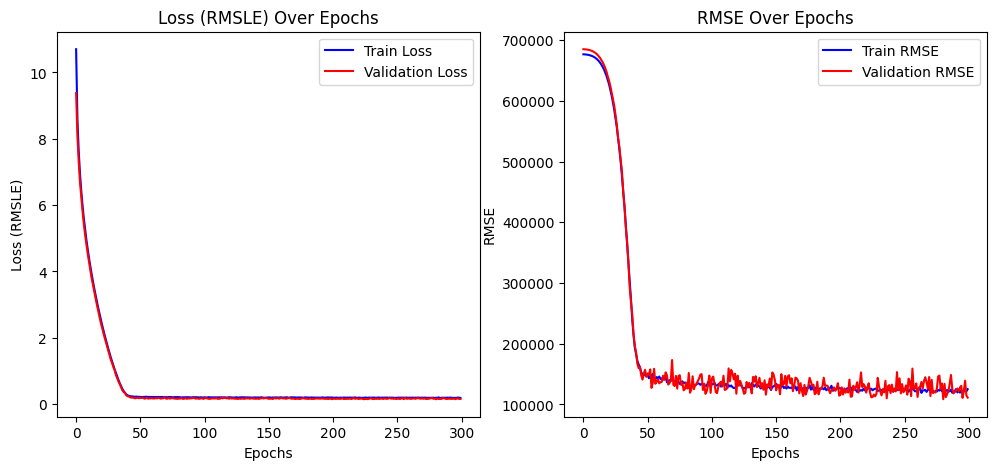

R^2: 0.8551
MAE: 71439.05
RMSE: 111585.86
MAPE: 11.18
RMSLE: 0.1505


In [ ]:
# Define a More Complex Neural Network with RMSLE
class HousePriceNN(nn.Module):
    def __init__(self, input_size):
        super(HousePriceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, RMSLE loss function & optimizer
input_size = X_train.shape[1]
model = HousePriceNN(input_size)

def RMSLELoss(y_pred, y_true):
    return torch.sqrt(nn.MSELoss()(torch.log1p(y_pred), torch.log1p(y_true)))  # RMSLE Loss function

criterion = RMSLELoss 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation monitoring (Reduced to 300 epochs & batch size 8)
epochs = 300
batch_size = 8
train_losses, val_losses, train_rmse, val_rmse = [], [], [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))  # Shuffle data

    batch_train_losses = []
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_train_losses.append(loss.item())

    # Compute training loss & RMSE
    train_loss = np.mean(batch_train_losses)
    with torch.no_grad():
        y_train_pred = model(X_train)
        train_rmse_value = torch.sqrt(nn.MSELoss()(y_train_pred, y_train)).item()

    # Compute validation loss & RMSE
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val).item()
        val_rmse_value = torch.sqrt(nn.MSELoss()(y_val_pred, y_val)).item()

    # Store results for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_rmse.append(train_rmse_value)
    val_rmse.append(val_rmse_value)

    # Print progress every 50 epochs
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse_value:.2f} | Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse_value:.2f}")

# Plot loss & RMSE curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(epochs), train_losses, label="Train Loss", color="blue")
axes[0].plot(range(epochs), val_losses, label="Validation Loss", color="red")
axes[0].set_title("Loss (RMSLE) Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss (RMSLE)")
axes[0].legend()

axes[1].plot(range(epochs), train_rmse, label="Train RMSE", color="blue")
axes[1].plot(range(epochs), val_rmse, label="Validation RMSE", color="red")
axes[1].set_title("RMSE Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("RMSE")
axes[1].legend()

plt.show()

# Model evaluation on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()
    y_test_np = y_test.numpy().flatten()

# Compute metrics
fnn2_r2, fnn2_mae, fnn2_mse, fnn2_rmse, fnn2_mape, fnn2_rmsle = evaluate_model(y_test_np, y_pred)

# Print results
print(f"R^2: {fnn2_r2:.4f}")
print(f"MAE: {fnn2_mae:.2f}")
print(f"RMSE: {fnn2_rmse:.2f}")
print(f"MAPE: {fnn2_mape:.2f}")
print(f"RMSLE: {fnn2_rmsle:.4f}")

After applying **SMOGN, RMSLE loss, and adjusting batch size & epochs**, the model showed **an increase in R²**, indicating better overall fit. However, other metrics (**MAE, RMSE, MAPE, and RMSLE**) were **significantly higher** compared to the previous model. 

**Possible Explanation:** 
- The model likely **overestimated some house prices**, leading to large errors.  
- RMSLE **penalizes underestimation more**, which may have caused it to predict too high.  
- SMOGN might have **changed the data distribution**, making predictions less accurate on the test set.  

Next Steps: Testing **CNN & RNN Models**


### 6.3 Convolutional Neural Network

The model processes tabular data by applying 1D convolutional layers to capture feature relationships.\
**Model Structure:**
- 4 convolutional layers (32-64-128-256 filters, kernel size 3)
- Fully connected layers (512-256-128-64-1 neurons)
- ReLU activation & dropout (0.3) to prevent overfitting
- RMSE loss function for better raw value prediction

Epoch [50/300] | Train Loss: 94876.7267, Train RMSE: 92861.98 | Val Loss: 98486.2031, Val RMSE: 98486.20
Epoch [100/300] | Train Loss: 84614.6419, Train RMSE: 86452.32 | Val Loss: 98339.6094, Val RMSE: 98339.61
Epoch [150/300] | Train Loss: 79251.2692, Train RMSE: 75757.01 | Val Loss: 94530.5078, Val RMSE: 94530.51
Epoch [200/300] | Train Loss: 71630.9213, Train RMSE: 70539.14 | Val Loss: 93073.1953, Val RMSE: 93073.20
Epoch [250/300] | Train Loss: 70085.0570, Train RMSE: 73098.48 | Val Loss: 93563.4922, Val RMSE: 93563.49
Epoch [300/300] | Train Loss: 65757.4593, Train RMSE: 66739.01 | Val Loss: 93229.2969, Val RMSE: 93229.30


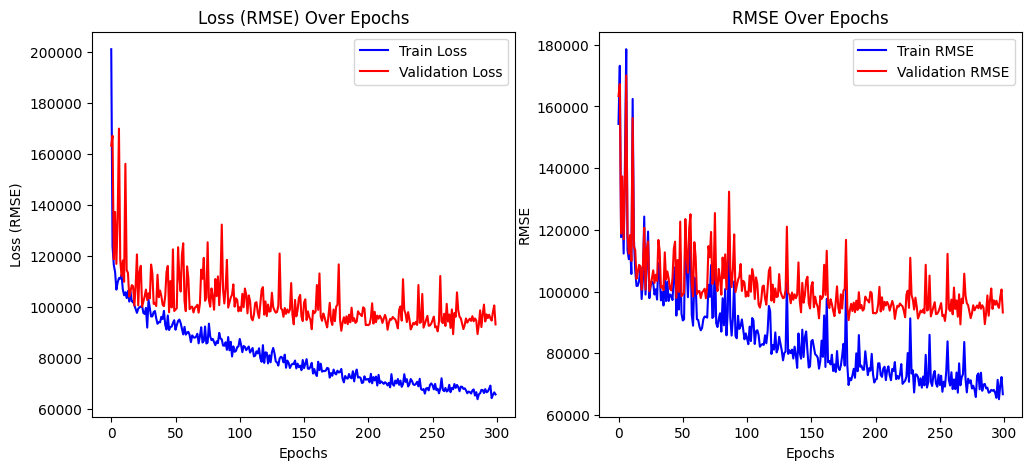

R^2: 0.8133
MAE: 55011.35
RMSE: 84340.13
MAPE: 9.36
RMSLE: 0.1314


In [ ]:
# Convert dataset to PyTorch tensors
X = torch.tensor(data_standardized.drop(columns=['Price']).values, dtype=torch.float32)
y = torch.tensor(data_standardized['Price'].values, dtype=torch.float32).view(-1, 1)  # Reshape for PyTorch

# Reshape data for CNN (Adding a channel dimension)
X = X.unsqueeze(1)  # CNN expects (batch_size, channels, features)

# Split data into train, validation & test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% Train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% Val, 15% Test

# Define CNN Model
class HousePriceCNN(nn.Module):
    def __init__(self, input_size):
        super(HousePriceCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(input_size * 256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)  # Output layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # Flatten before passing to FC layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)  # Output layer
        return x

# Initialize model, RMSE loss function & optimizer
input_size = X_train.shape[2]  # Features count
model = HousePriceCNN(input_size)

def RMSELoss(y_pred, y_true):
    return torch.sqrt(nn.MSELoss()(y_pred, y_true))  # RMSE Loss function

criterion = RMSELoss  # Using RMSE loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation monitoring (300 epochs, batch size 8)
epochs = 300
batch_size = 8
train_losses, val_losses, train_rmse, val_rmse = [], [], [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))  # Shuffle data

    batch_train_losses = []
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_train_losses.append(loss.item())

    # Compute training loss & RMSE
    train_loss = np.mean(batch_train_losses)
    with torch.no_grad():
        y_train_pred = model(X_train)
        train_rmse_value = torch.sqrt(nn.MSELoss()(y_train_pred, y_train)).item()

    # Compute validation loss & RMSE
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val).item()
        val_rmse_value = torch.sqrt(nn.MSELoss()(y_val_pred, y_val)).item()

    # Store results for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_rmse.append(train_rmse_value)
    val_rmse.append(val_rmse_value)

    # Print progress every 50 epochs
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse_value:.2f} | Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse_value:.2f}")

# Plot loss & RMSE curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(epochs), train_losses, label="Train Loss", color="blue")
axes[0].plot(range(epochs), val_losses, label="Validation Loss", color="red")
axes[0].set_title("Loss (RMSE) Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss (RMSE)")
axes[0].legend()

axes[1].plot(range(epochs), train_rmse, label="Train RMSE", color="blue")
axes[1].plot(range(epochs), val_rmse, label="Validation RMSE", color="red")
axes[1].set_title("RMSE Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("RMSE")
axes[1].legend()

plt.show()

# Model evaluation on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()
    y_test_np = y_test.numpy().flatten()

# Compute metrics
cnn_r2, cnn_mae, cnn_mse, cnn_rmse, cnn_mape, cnn_rmsle = evaluate_model(y_test_np, y_pred)

# Print results
print(f"R^2: {cnn_r2:.4f}")
print(f"MAE: {cnn_mae:.2f}")
print(f"RMSE: {cnn_rmse:.2f}")
print(f"MAPE: {cnn_mape:.2f}")
print(f"RMSLE: {cnn_rmsle:.4f}")

The CNN model performed worse than FNN, with higher errors across all metrics.\
Validation loss fluctuates significantly, indicating unstable learning and the gap between training and validation loss suggests overfitting.

**Possible Explanation:**
- CNNs are better suited for spatial data, while FNNs handle tabular data more effectively.
- Feature relationships in housing data may not benefit from convolutional layers.
- The model may struggle to extract meaningful patterns from structured numerical inputs.

### 6.4 Validating Data for RNN

Before using an **RNN**, I need to check if my data has sequential dependencies. I will analyze autocorrelation in key features (`Price`, `Area`, `Year`, `Rooms`) to see if past values influence future ones. If no strong autocorrelation exists, **RNNs** are likely not suitable for this problem.

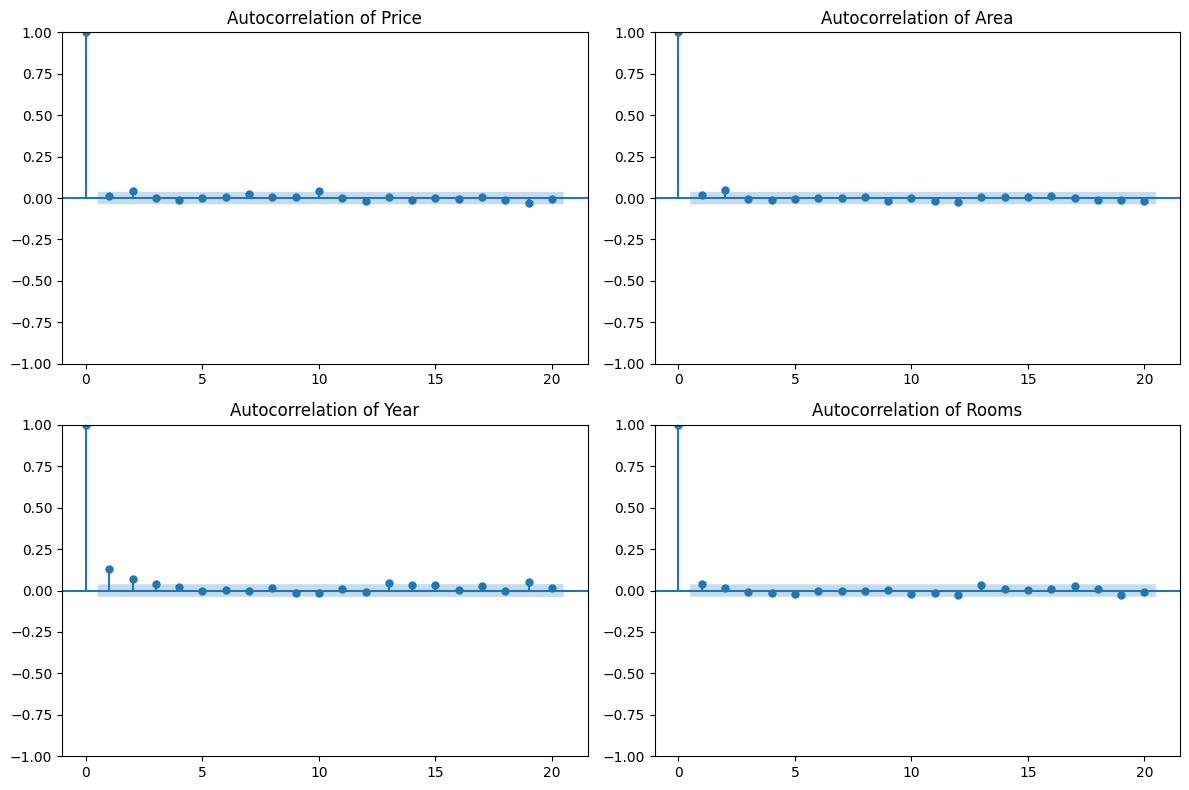

In [157]:
# Select numerical columns for autocorrelation analysis
numerical_columns = ['Price', 'Area', 'Year', 'Rooms']

# Set up the plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Plot autocorrelation for each numerical column
for i, col in enumerate(numerical_columns):
    sm.graphics.tsa.plot_acf(data[col], lags=20, ax=axes[i], title=f"Autocorrelation of {col}")

# Adjust layout
plt.tight_layout()
plt.show()

The autocorrelation plots show **no significant sequential patterns** in the data - autocorrelation drops to near zero after lag 1. This confirms that **RNNs** are not a good fit, as the dataset does not follow a time-series structure. 

### 6.5 Neural Network Results & Conclusions

We built **two neural network models**, **FNN** and **CNN**, to predict house prices. **FNN** performed better, while **CNN** showed higher errors, likely because **CNNs** are designed for spatial data, not tabular features.

Additionally, we validated the dataset for **RNNs** using autocorrelation analysis and found no sequential dependencies, meaning **RNNs** are not suitable for this task.

**Tree-based models** remain the strongest approaches for this problem.

## 7. Model Comparison & Feature Importance

### 7.1 Compare All Model Metrics

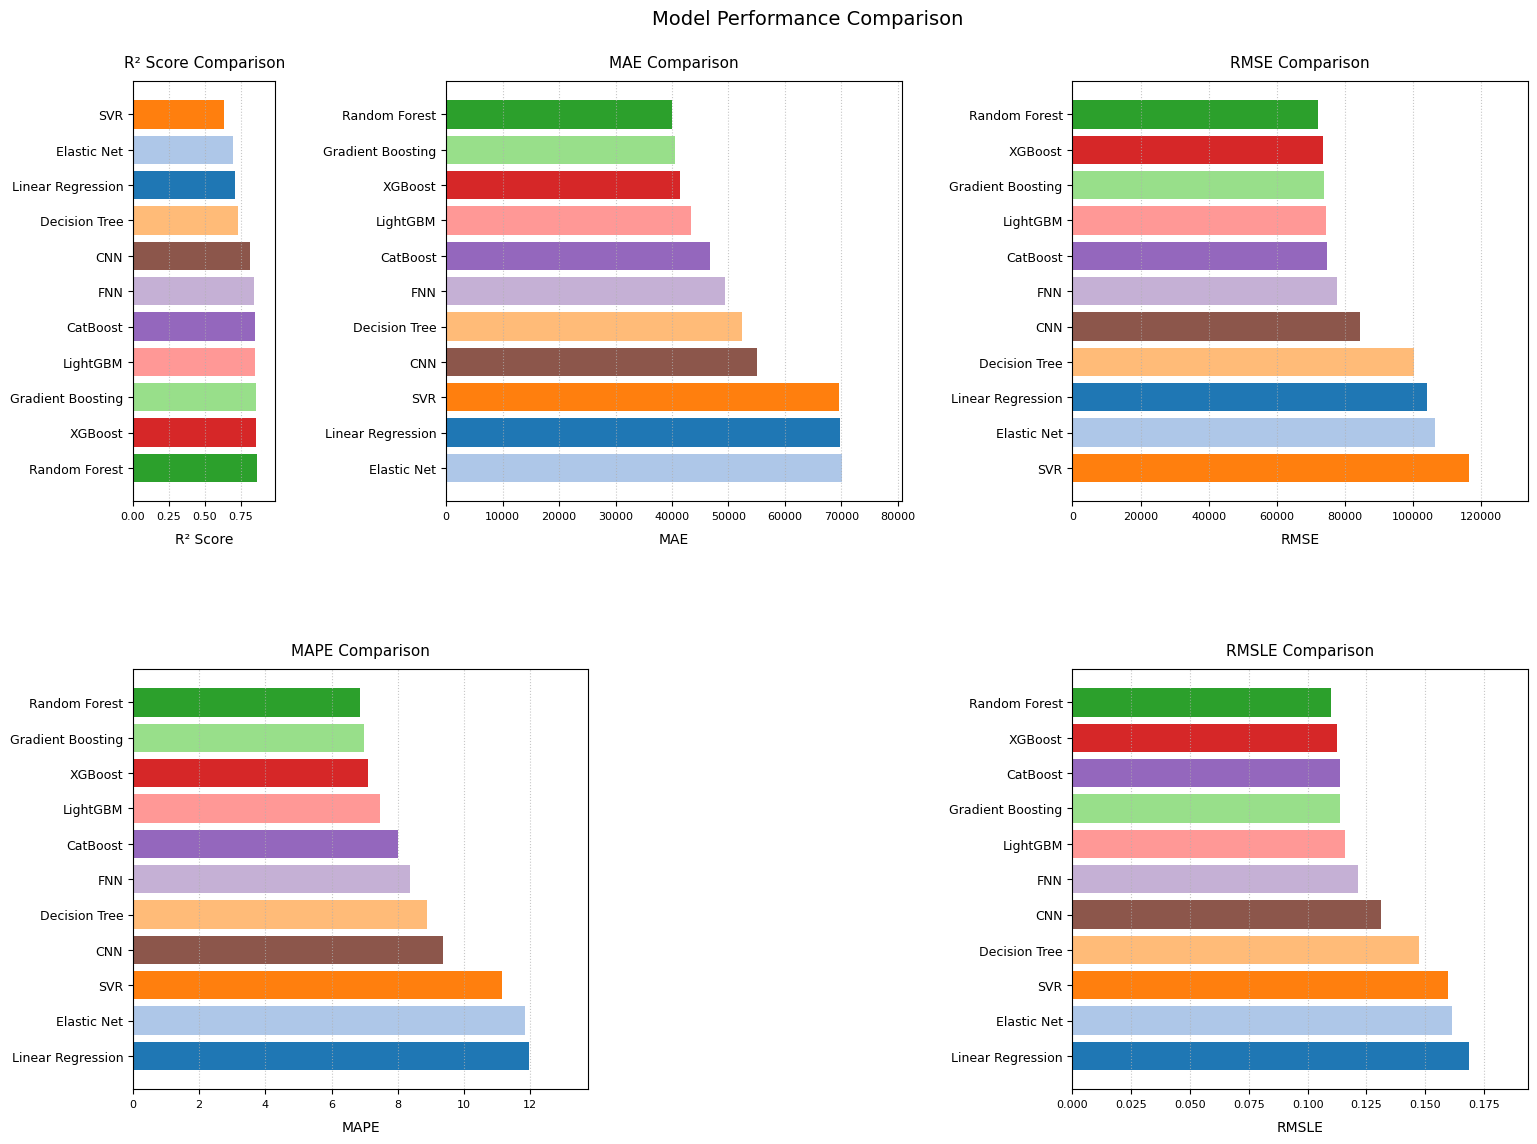

In [167]:
# Add Neural Network Models to Metrics Dictionary
r2_scores.update({
    "FNN": fnn1_r2,
    "CNN": cnn_r2
})

mae_scores.update({
    "FNN": fnn1_mae,
    "CNN": cnn_mae
})

rmse_scores.update({
    "FNN": fnn1_rmse,
    "CNN": cnn_rmse
})

mape_scores.update({
    "FNN": fnn1_mape,
    "CNN": cnn_mape
})

rmsle_scores.update({
    "FNN": fnn1_rmsle,
    "CNN": cnn_rmsle
})


# Generate model colors using a colormap
models = list(r2_scores.keys())
cmap = plt.get_cmap('tab20')  # Using a colormap with enough colors
model_colors = {model: cmap(i) for i, model in enumerate(models)}

# Create figure with enhanced GridSpec configuration
fig = plt.figure(figsize=(18, 12)) 
gs = gridspec.GridSpec(2, 5, width_ratios=[1,1,1,1,1], wspace=1.2, hspace=0.4)

# Top row assignments
ax0 = plt.subplot(gs[0, 0])  
ax1 = plt.subplot(gs[0, 1:3])  
ax2 = plt.subplot(gs[0, 3:5])   

# Bottom row - centered plots
ax3 = plt.subplot(gs[1, 0:2])  
ax4 = plt.subplot(gs[1, 3:5]) 

# Configure all axes
for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='y', labelsize=9)  # Smaller y-axis labels
    ax.xaxis.set_tick_params(labelsize=8)  # Smaller x-axis labels

# Plotting function with label adjustments
def plot_metric(ax, metric_name, metric_values):
    sorted_metrics = dict(sorted(metric_values.items(), 
                               key=lambda item: item[1], 
                               reverse=True))
    colors = [model_colors[model] for model in sorted_metrics.keys()]
    
    bars = ax.barh(list(sorted_metrics.keys()), 
                 list(sorted_metrics.values()), 
                 color=colors)
    
    ax.set_title(f"{metric_name} Comparison", fontsize=11, pad=10)
    ax.set_xlabel(metric_name, fontsize=10, labelpad=8)
    ax.grid(axis='x', linestyle=':', alpha=0.7)
    
    # Set dynamic x-lim padding
    xmax = max(metric_values.values())
    ax.set_xlim(left=0, right=xmax * 1.15)  # Add 15% padding

# Plot all metrics
metrics_data = [
    (ax0, "R² Score", r2_scores),
    (ax1, "MAE", mae_scores),
    (ax2, "RMSE", rmse_scores),
    (ax3, "MAPE", mape_scores),
    (ax4, "RMSLE", rmsle_scores)
]

for ax, name, values in metrics_data:
    plot_metric(ax, name, values)

# Final layout adjustments
plt.subplots_adjust(top=0.92, bottom=0.08)
plt.suptitle("Model Performance Comparison", fontsize=14)
plt.show()


**Random Forest** delivered the best results, followed by boosting algorithms (**Gradient Boosting, XGBoost, LightGBM, CatBoost**). **Neural networks (FNN, CNN)** performed worse, struggling to outperform tree-based models. **Regression models** and **SVR** showed the weakest performance, indicating that more complex, non-linear models are better suited for this task.

### 7.2 Feature Importance

 I will analyze which features impact predictions the most. Using feature importance, I can understand how the model makes decisions and identify key drivers of house prices.

Since `X_train` and `y_train` were previously tensors (for neural networks), I reverted them back to standard NumPy arrays to ensure compatibility with tree-based models. It allows for seamless feature importance analysis, model interpretation, and further experiments to enhance performance. 

In [ ]:
# Label encode categorical features 
label_encoder_floor = LabelEncoder()
label_encoder_region = LabelEncoder()

data_tree['Floor'] = label_encoder_floor.fit_transform(data_tree['Floor'])
data_tree['Region'] = label_encoder_region.fit_transform(data_tree['Region'])

# Compute weights for Region, Floor, and Rooms
region_weights = compute_weights(data_tree, 'Region')
floor_weights = compute_weights(data_tree, 'Floor')
room_weights = compute_weights(data_tree, 'Rooms') 

# Map weights to each sample
data_tree['region_weight'] = data_tree['Region'].map(region_weights)
data_tree['floor_weight'] = data_tree['Floor'].map(floor_weights)
data_tree['room_weight'] = data_tree['Rooms'].map(room_weights)

# Combine weights (average or product method)
data_tree['sample_weight'] = (data_tree['region_weight'] + data_tree['floor_weight'] + data_tree['room_weight']) / 3  # Averaging method

# Define features and target
features = data_tree.drop(columns=['Price', 'region_weight', 'floor_weight', 'room_weight', 'sample_weight'])  # Exclude weight columns
target = data_tree['Price']

# Split data with weights
X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
    features, target, data_tree['sample_weight'], test_size=0.2, random_state=42
)

For that I use function which I already used before.

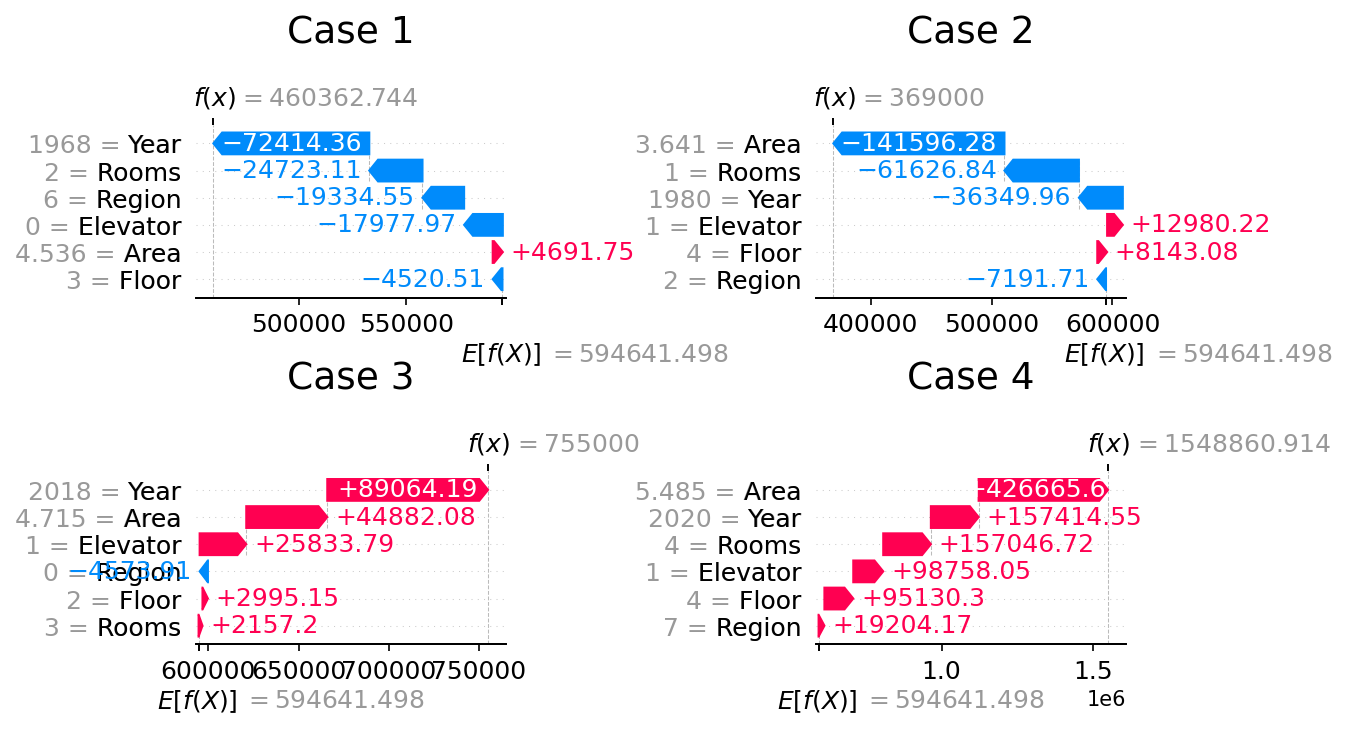

In [ ]:
# List to store SHAP explanations and their corresponding data
explanations = []

# Monkey-patch to capture complete explanation data
original_waterfall_plot = shap.waterfall_plot

def capturing_plot(explanation, *args, **kwargs):
    explanations.append({
        'values': explanation.values,
        'base_value': explanation.base_values,
        'data': explanation.data,
        'feature_names': explanation.feature_names
    })
    plt.close()

shap.waterfall_plot = capturing_plot

# Generate 4 explanations by running 4 times
for _ in range(4):
    check_feature_importance(best_rf_model, X_test)

# Restore original function
shap.waterfall_plot = original_waterfall_plot

# Configure plot parameters BEFORE creating figure
plt.rcParams.update({
    'font.size': 14,           
    'axes.titlesize': 16,        
    'axes.labelsize': 12,         
    'xtick.labelsize': 10,        
    'ytick.labelsize': 10,       
    'figure.autolayout': False    
})

# Create MASSIVE figure with optimized proportions
fig, axes = plt.subplots(2, 2, figsize=(30, 30), dpi=150)  # 50% larger than before
axes = axes.flatten()

# Plot with enhanced spacing
for i, exp_data in enumerate(explanations[:4]):
    # Recreate explanation object
    exp = shap.Explanation(
        values=exp_data['values'],
        base_values=exp_data['base_value'],
        data=exp_data['data'],
        feature_names=exp_data['feature_names']
    )
    
    # Select current axis
    ax = axes[i]
    plt.figure(fig.number)
    plt.sca(ax)
    
    # Create plot with adjusted parameters
    shap.plots.waterfall(
        exp,
        show=False,
    )
    
    # Custom adjustments
    ax.set_title(f'Case {i+1}', pad=20, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add breathing room around plot
    plt.draw()

# Final layout magic
plt.tight_layout(pad=6.0)
plt.subplots_adjust(
    wspace=1,  
    hspace=1    
)
plt.show()

Mostly, `Area` and `Year` have the highest importance in predicting house prices, followed by `Eleveator`, `Region`, `Rooms`. `Floor` has the lowest importance.

### 7.3 Deep Dive into model predictions

To understand why the model struggles with certain predictions, I will:
- Identify the 10 worst predictions (largest absolute errors).
- Compare actual vs predicted prices.
- Analyze possible reasons for these misclassifications.

In [ ]:
# Get predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Create a DataFrame to compare actual vs. predicted values
predictions_df = pd.DataFrame({
    "Actual Price": y_test.values,
    "Predicted Price": y_pred,
    "Absolute Error": np.abs(y_test.values - y_pred)
})

# Add the corresponding feature values from X_test
features_df = pd.DataFrame(X_test, columns=X_test.columns)  # Convert X_test to DataFrame if needed
predictions_df = pd.concat([predictions_df, features_df.reset_index(drop=True)], axis=1)

# Decode categorical columns back to original values
predictions_df["Floor"] = label_encoder_floor.inverse_transform(predictions_df["Floor"].astype(int))
predictions_df["Region"] = label_encoder_region.inverse_transform(predictions_df["Region"].astype(int))

# Back-transform `Area` from Box-Cox to original scale
if lambda_area == 0:
    predictions_df["Area"] = np.exp(predictions_df["Area"])  # If lambda == 0, use exp()
else:
    predictions_df["Area"] = inv_boxcox(predictions_df["Area"], lambda_area)  # Use inverse Box-Cox formula

# Find the 10 worst predictions (largest errors)
worst_predictions = predictions_df.nlargest(10, "Absolute Error")

# Format numerical values to avoid scientific notation
worst_predictions["Predicted Price"] = worst_predictions["Predicted Price"].apply(lambda x: f"{x:,.2f}")
worst_predictions["Actual Price"] = worst_predictions["Actual Price"].apply(lambda x: f"{x:,.2f}")
worst_predictions["Absolute Error"] = worst_predictions["Absolute Error"].apply(lambda x: f"{x:,.2f}")
worst_predictions["Area"] = worst_predictions["Area"].apply(lambda x: f"{x:,.2f}")  # Format Area

# Display the worst predictions along with properly formatted columns
print(worst_predictions.to_string(index=False))

Actual Price Predicted Price Absolute Error   Area  Elevator  Year  Rooms     Floor         Region
  864,150.00    1,548,860.91     684,710.91 111.08      1.00  2020   4.00 5+ piętro   Konstantynów
1,215,000.00      810,788.51     404,211.49  73.51      1.00  2015   4.00  4 piętro       Wieniawa
  385,000.00      721,735.51     336,735.51  79.15      0.00  1910   4.00  3 piętro    Śródmieście
1,189,000.00      858,253.04     330,746.96  98.62      0.00  1930   3.00  1 piętro   Stare Miasto
  927,384.00      598,500.93     328,883.07  45.46      1.00  2016   2.00  4 piętro    Śródmieście
  950,000.00      644,564.44     305,435.56  72.86      0.00  1980   4.00  3 piętro Czuby Północne
  731,500.00      463,908.26     267,591.74  36.70      1.00  1936   2.00  1 piętro    Śródmieście
  890,000.00      636,771.03     253,228.97  64.53      0.00  1936   3.00  2 piętro   Stare Miasto
  412,815.00      655,841.95     243,026.95  37.70      1.00  2024   2.00  2 piętro    Śródmieście
1,225,000.

The patterns in poor model predictions remained unchanged - most of these listings have 4 or more rooms and larger-than-median area. SMOGN is unlikely to help, as the high prices could be due to expensive renovations or overpricing by owners. 

To improve predictions, it would be optimal to include an additional feature that assesses **property condition**, based on factors like interior quality, renovation status, and materials used, which may significantly impact pricing. 

## 8. Final Model & Predictions

### 8.1 Save Random Forest Model

Save Random Forest model from 5.5 section and all necessary components to make predictions in the future.

In [183]:
joblib.dump(best_rf_model, 'model_components/random_forest_model.pkl')
joblib.dump(label_encoder_floor, 'model_components/label_encoder_floor.pkl')
joblib.dump(label_encoder_region, 'model_components/label_encoder_region.pkl')
joblib.dump(lambda_area, 'model_components/lambda_area.pkl')
joblib.dump(region_weights, 'model_components/region_weights.pkl')
joblib.dump(floor_weights, 'model_components/floor_weights.pkl')
joblib.dump(room_weights, 'model_components/room_weights.pkl')

['model_components/room_weights.pkl']

### 8.2 Predictions on New Data

Firstly, I will load the saved model and all its components to make predictions on new data.

In [ ]:
# Load necessary encoders and trained model
label_encoder_floor = joblib.load("model_components/label_encoder_floor.pkl")
label_encoder_region = joblib.load("model_components/label_encoder_region.pkl")
rf_model = joblib.load("model_components/random_forest_model.pkl")
lambda_area = joblib.load("model_components/lambda_area.pkl")

# Load precomputed weights
region_weights = joblib.load("model_components/region_weights.pkl")
floor_weights = joblib.load("model_components/floor_weights.pkl")
room_weights = joblib.load("model_components/room_weights.pkl")

Now let's test model on some new data to check how it works. For that I will use new advertisements from Otodom, which model has never seen before.

In [ ]:
expected_features = ['Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']
joblib.dump(expected_features, 'model_components/expected_features.pkl')

['model_components/expected_features.pkl']

![image1.png](description_images/image1.jpg)

In [ ]:
# Define user input
user_input = {
    'Rooms': 3,
    'Area': 59.5,  
    'Floor': '1 piętro',
    'Region': 'Bronowice',
    'Elevator': 0, 
    'Year': 2024
}

predicted_price, conf_interval = predict_house_price(
    user_input, 
    rf_model, 
    label_encoder_floor, 
    label_encoder_region, 
    lambda_area, 
    region_weights, 
    floor_weights, 
    room_weights, 
    expected_features, 
    significance_level=0.05
)
print(f"Predicted House Price: {predicted_price} PLN")
print(f"95% Confidence Interval: {conf_interval[0]} - {conf_interval[1]} PLN")

✅ Features expected by model: ['Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']
✅ Features provided for prediction: ['Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']
Predicted House Price: 631336.7389825603 PLN
95% Confidence Interval: 498008.3400580956 - 764665.1379070252 PLN


![image2.png](description_images/image2.jpg)

In [ ]:
# Define user input
user_input = {
    'Rooms': 3,
    'Area': 57.41,  
    'Floor': '5 piętro',
    'Region': 'Kalinowszczyzna',
    'Elevator': 0, 
    'Year': 2012
}

predicted_price, conf_interval = predict_house_price(
    user_input, 
    rf_model, 
    label_encoder_floor, 
    label_encoder_region, 
    lambda_area, 
    region_weights, 
    floor_weights, 
    room_weights, 
    expected_features, 
    significance_level=0.01
)
print(f"Predicted House Price: {predicted_price} PLN")
print(f"95% Confidence Interval: {conf_interval[0]} - {conf_interval[1]} PLN")

✅ Features expected by model: ['Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']
✅ Features provided for prediction: ['Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']
Predicted House Price: 635504.8125148023 PLN
95% Confidence Interval: 352858.56134002475 - 918151.06368958 PLN


![image3.png](description_images/image3.jpg)

In [ ]:
# Define user input
user_input = {
    'Rooms': 2,
    'Area': 35.3,  
    'Floor': 'parter',
    'Region': 'Wieniawa',
    'Elevator': 0, 
    'Year': 1964
}

predicted_price, conf_interval = predict_house_price(
    user_input, 
    rf_model, 
    label_encoder_floor, 
    label_encoder_region, 
    lambda_area, 
    region_weights, 
    floor_weights, 
    room_weights, 
    expected_features,  
    significance_level=0.01
)
print(f"Predicted House Price: {predicted_price} PLN")
print(f"95% Confidence Interval: {conf_interval[0]} - {conf_interval[1]} PLN")

✅ Features expected by model: ['Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']
✅ Features provided for prediction: ['Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']
Predicted House Price: 380934.532 PLN
95% Confidence Interval: 340787.087358726 - 421081.976641274 PLN


The **Random Forest model** predicts house prices accurately based on key features. Since manual predictions are inconvenient, I use a **FastAPI app** for faster queries. Some listings lack details (e.g., floor, year, elevator), so missing values are **filled with the median** to ensure reliable predictions.

## 9. Conclusion

This project explored multiple **machine learning and deep learning algorithms** for house price prediction in Lublin. After extensive evaluation, **Random Forest** achieved the best results and performed well on real-world data. The workflow included **data scraping**, **cleaning**, **exploratory analysis**, **feature engineering**, **handling outliers**, **Box-Cox transformations** and **standardization**. These steps ensured a well-preprocessed dataset, leading to a robust and reliable predictive model. 